In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.interpolate import interp1d, UnivariateSpline, SmoothBivariateSpline, make_splrep, PPoly
from scipy.stats import linregress
import os
from pathlib import Path
import re
import finufft

# Function to read .okc database files from Visit
def extract_fields_from_okc(file_path, fields):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Read header to get number of fields and points
    header = lines[0].strip()
    n_fields, n_points, foo = map(int, header.split())
    # Read field names in the next n_fields lines
    field_names = [line.strip() for line in lines[1:(n_fields + 1)]]

    # Data starts at line 2 * n_fields + 1
    start_data_lines = (2 * n_fields + 1)

    df = pd.read_csv(file_path, sep=r'\s+', skiprows=start_data_lines, names=field_names)
    sliced_df = df[fields]
    return sliced_df

def cartesian_df_to_polar(dataframe):
    df = dataframe
    r = np.sqrt(df['x'].to_numpy() ** 2 + df['y'].to_numpy() ** 2)
    theta = np.arctan2(df['y'].to_numpy(), df['x'].to_numpy())
    r_mean = np.mean(r)
    r_fluct = r - r_mean
    return theta, r_mean, r_fluct

# Function to calculate FFT after interpolation using point to point interpolation
# Using os_fact, data can over oversampled
def interpolated_spline_FFT(x, f, os_fact=1, n_modes=50):
    # Define uniform x range 
    x_uniform = np.linspace(x[0], x[-1], int(os_fact*len(x)), endpoint=True)

    # Interpolate r to uniform x
    spline = interp1d(x, f, kind='cubic')
    f_uniform = spline(x_uniform)
    dx = (x_uniform[1] - x_uniform[0])

    # Perform the Fourier Transform
    fft_coeffs = np.fft.fft(f_uniform)
    spect_wave_nums = np.fft.fftfreq(len(f_uniform), dx)

    # Convert to one-sided over angular frequency and normalize by spacing dx
    pos_ind = len(spect_wave_nums) // 2
    if n_modes < 0:
        wave_nums = 2 * np.pi * spect_wave_nums[:pos_ind]   
        amplitudes = 2 * np.abs(fft_coeffs)[:pos_ind] / len(x_uniform)
    else:
        if n_modes > pos_ind: print("[WARNING] requested number of modes is higher than possible")
        wave_nums = 2 * np.pi * spect_wave_nums[:n_modes]
        amplitudes = np.abs(fft_coeffs)[:n_modes] / len(x_uniform)
    return wave_nums, amplitudes

# Function to calculate FFT after interpolation using an univariate spline, smooting = 0 is equal to the interp1d function
def interpolated_smooth_FFT(x, f, n_grid=-1, n_modes=-1, smoothing=0):
    # Define unifrom grid with n_grid gridpoints
    if n_grid < 0: n_grid = len(x)
    x_uniform = np.linspace(x[0], x[-1], n_grid, endpoint=False)

    # Interpolate f to x_uniform
    spline = UnivariateSpline(x, f, s=smoothing)
    f_uniform = spline(x_uniform)
    dx = x_uniform[1] - x_uniform[0]

    # Perform the Fourier Transform
    fft_coeffs = np.fft.fft(f_uniform)
    spect_wave_nums = np.fft.fftfreq(len(f_uniform), d=dx)
    
    # Convert to one-sided over angular wavenumber and normalize the amplitude
    pos_ind = len(spect_wave_nums) // 2
    if n_modes < 0:
        wave_nums = 2 * np.pi * spect_wave_nums[:pos_ind]   
        amplitudes = np.abs(fft_coeffs)[:pos_ind] * dx
    else:
        if n_modes > pos_ind: print("[WARNING] requested number of modes is higher than possible")
        wave_nums = 2 * np.pi * spect_wave_nums[:n_modes]
        amplitudes = np.abs(fft_coeffs)[:n_modes] * dx

    return wave_nums, amplitudes

def interpolated_NUFFT(x_norm, f, modes, r_mean, n_grid=-1):
    # Define unifrom grid with n_grid gridpoints
    x = x_norm + np.pi
    if n_grid < 0: n_grid = len(x)
    x_uniform = np.linspace(x[0], x[-1], n_grid, endpoint=True)

    # Interpolate f to x_uniform
    spline = interp1d(x, f, kind='cubic')
    f_uniform = spline(x_uniform)
    dx = x_uniform[1] - x_uniform[0]

    wave_nums_norm = np.asarray(modes, dtype=np.float64)
    wave_nums = wave_nums_norm / r_mean  
    f_uniform = np.asarray(f_uniform, dtype=np.complex128)
    coeffs = finufft.nufft1d3(x_uniform, f_uniform, wave_nums_norm)
    amplitudes = np.abs(coeffs) * dx
    return wave_nums, amplitudes

def least_squares_fit(x_norm, f, n_modes=10, modes=None, r_mean=1.0):
    # Manual mode switch
    if modes is None: wave_nums_norm = np.arange(n_modes)
    else: wave_nums_norm = modes

    wave_nums = wave_nums_norm / r_mean  

    # Design matrix for complex exponentials
    A = np.exp(1j * np.outer(x_norm, wave_nums_norm))  # shape (N, kmax)
    
    # Solve least squares for Fourier coefficients
    coeffs, *_ = np.linalg.lstsq(A, f, rcond=None)
    amplitudes = np.abs(coeffs)
    
    return wave_nums, amplitudes

def get_dominant_mode(theta, signal):
    wavenumbers, amplitudes = interpolated_spline_FFT(theta, signal)
    dominant_mode = np.argmax(amplitudes)
    
    return int(dominant_mode)

def get_cases(casename, criterion=None):
    username = os.getlogin()
    filepath = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results")
    runs_csv_dir = filepath / "caselist_post_proc.csv"
    runs_df = pd.read_csv(runs_csv_dir, dtype=str)
    # filter runs for the ones needed here
    if criterion is None:
        runs_criterion_df = runs_df
    else:
        runs_criterion_df = runs_df[runs_df[criterion] == 'x']
        
    cases_df = runs_criterion_df[runs_criterion_df['case'] == casename]
    
    directories = []
    return cases_df

In [3]:
"""Define general plotting parameters"""
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({"text.usetex": False, 
                     "font.family": "serif", 
                     "mathtext.fontset": "cm", 
                     "font.size": 9, 
                     "axes.labelsize": 9, 
                     "legend.fontsize": 8, 
                     "xtick.labelsize": 8, 
                     "ytick.labelsize": 8})
pagewidth = 6.3 * 1.2
w_plot_s = pagewidth * 0.5
h_plot_s = w_plot_s / 1.6
w_plot_mw = pagewidth * 0.75
h_plot_mw = w_plot_mw / 1.6
w_plot_fw = pagewidth * 1.0
h_plot_fw = w_plot_fw / 1.6
markers = ['o', 's', '^', 'X', 'v', 'P', 'd', 'p', '<']
colors_d = ['#1f4e79', '#a83232', '#d4a017', '#4b0082', '#2e6b3f']
colors_blu = [
    '#14213d',  # oxford blue
    '#0f3057',  # midnight blue
    '#1f4e79',  # navy blue
    '#76b0e0']  # light blue
colors_l = ['#76b0e0', '#f0827f', '#f2d98c', '#8a7bc9', '#7fc89b']
my_cmap_v = plt.get_cmap('viridis')
username = os.getlogin()

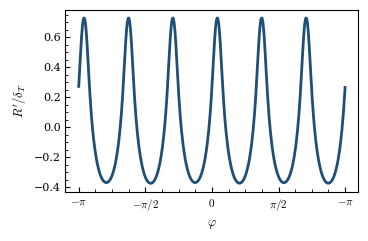

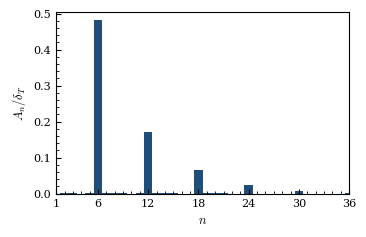

In [ ]:
"""Plot the isotherm radius of a selected case as well as the FFT of it
"""
# Define the paths of the isotherm data and read it
username = os.getlogin()
case_path = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/base_18.4k_phi_0.6")
filepath = case_path / "Uin_02.00_RUN02/database/Isotherm_T_3_t_100.00.okc"

df = extract_fields_from_okc(filepath, ['x', 'y'])
theta_unsorted, r_mean, r_fluc_unsorted = cartesian_df_to_polar(df)

# Get the indices that would sort theta and sort the arrays
sorted_indices = np.argsort(theta_unsorted)
theta = theta_unsorted[sorted_indices]
r_fluc = r_fluc_unsorted[sorted_indices]

# Perform FFT on radius fluctuation
r_fluc_omega, r_fluc_amp = interpolated_spline_FFT(theta, r_fluc, os_fact=1, n_modes=-1)

# Plot radius fluctuations over theta
fig, ax = plt.subplots(figsize=(w_plot_s, h_plot_s))
ax.plot(theta, r_fluc, c= '#1f4e79', linewidth=2)
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$R^{\prime} / \delta_T$')
ax.tick_params(axis='both', which='both', labelcolor='black', direction='in')
ax.set_xticks([-np.pi + 0.5 * np.pi * i for i in range(5)])
ax.set_xticklabels([r'$-\pi$', r'$-\pi / 2$', r'$0$', r'$\pi / 2$', r'$-\pi$'])
ax.minorticks_on()
fig.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Isotherms_phi06/Isotherm_02.00_02_unwrapped.png",
            dpi=300,bbox_inches='tight')

# Plot FFT
k_plot_lim = 36
fig, ax = plt.subplots(figsize=(w_plot_s, h_plot_s))
ax.bar(r_fluc_omega, r_fluc_amp, width=1, color='#1f4e79')
ax.set_xlabel(r'$n$')
ax.set_ylabel(r'$A_n / \delta_T$')
ax.set_xlim(0, k_plot_lim)
ax.tick_params(axis='both', which='both', labelcolor='black', direction='in')
ax.set_xticks([1, 6, 12, 18, 24, 30, 36])
ax.minorticks_on()
ax.set_xlim(left=1)
fig.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Isotherms_phi06/Isotherm_02.00_02_FFT.png",
            dpi=300,bbox_inches='tight')
plt.show()

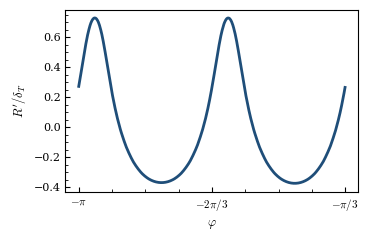

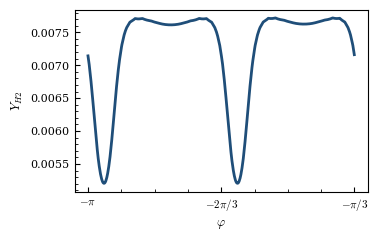

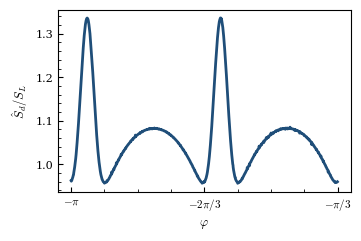

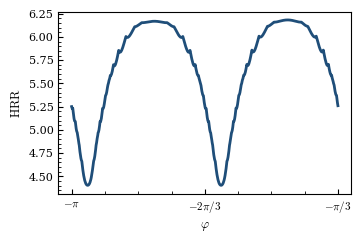

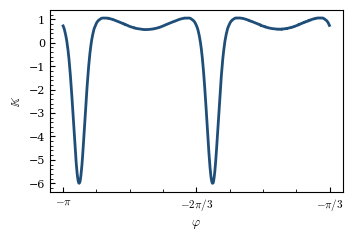

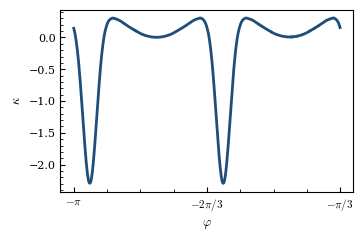

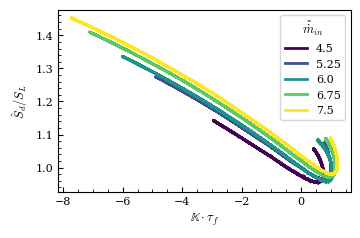

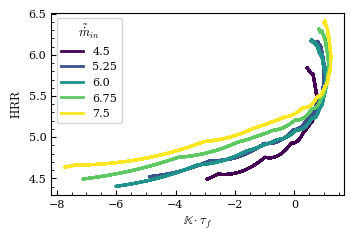

In [26]:
"""Plot flame surface properties"""

# Define case path
username = os.getlogin()
run_list = ["01.50_02", "01.75_01", "02.00_02", "02.25_02", "02.50_02"]
case1 = "base_18.4k_phi_0.6"
case_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/{case1}")

# Parameters for data extraction and plotting
time_list = None        # specify time at which quantity should be plotted (default=None)
run_idx = 2             # run_list index for detailed plots
range_frac = 1 / 3      # specify the angular range to be plotted (0-1)
colors = my_cmap_v(np.linspace(0, 1.0, len(run_list)))

def plot_stretch_quant(data, quantity, colors, y_axis_label='placeholder'):
    fig, ax = plt.subplots(figsize=(w_plot_s, h_plot_s))
    for i in range(len(data)):
        ax.plot(data[i]["stretch"], data[i][quantity], marker='none', markersize=1, color=colors[i], markerfacecolor='none', 
                linewidth=2, label=data[i]["label"])
        ax.set_xlabel(r'$\mathbb{K}\cdot \tau_f$')
        ax.set_ylabel(y_axis_label)
        ax.tick_params(axis='both', which='both', labelcolor='black', direction='in')
        ax.minorticks_on()
        ax.legend(title=r'$\tilde{\dot{m}}_{in}$')
    return fig

def plot_theta_quant(data, quantitiy, run_idx, range_idx=-0, label=None, ax=None, color='#1f4e79'):
    if ax is None: fig, ax = plt.subplots(figsize=(w_plot_s, h_plot_s))
    if label is None: label = 'placeholder'

    ax.plot(data[run_idx]["theta"][:range_idx], data[run_idx][quantitiy][:range_idx], c=color, label=label, linewidth=2)
    ax.set_xlabel(r'$\varphi$')
    ax.set_ylabel(label)
    ax.tick_params(axis='both', which='both', labelcolor='black', direction='in')
    ax.set_xticks([-np.pi + 0.3333 * np.pi * i for i in range(3)])
    ax.set_xticklabels([r'$-\pi$', r'$-2\pi / 3$', r'$-\pi / 3$'])
    ax.minorticks_on()

# Define data list and extract data from runs
data = []
for i, run in enumerate(run_list):
    # Define working dir and list all available files
    u_in, run_num = run.split("_")
    run_dir = case_dir / f"Uin_{u_in}_RUN{run_num}"
    db_files_dir = run_dir / "database"
    all_files = os.listdir(db_files_dir)

    # Filter files that match the pattern and extract time
    matches = []
    for f in all_files:
        match = re.match(r"Isotherm_T_3_t_(\d+.\d+)", f)
        if match:
            time_val = float(match.group(1))
            matches.append((f, time_val))

    # Find the file with the largest time
    if matches:
        if time_list is None:
            final_Isocon = max(matches, key=lambda x: x[1])[0]
        else:
            time = time_list[i]

            matching_files = [f for f, t in matches if t == time]
            if matching_files:
                final_Isocon = matching_files[0]
            else:
                raise ValueError(f"No Isotherm file found for time {time} in {db_files_dir}")
    else:
        print("[WARNING] No matching files found.")
    filepath = db_files_dir / final_Isocon
    df = extract_fields_from_okc(filepath, ['x', 'y', 's1', 's6', 's10','s11', 's12', 's13' , 's18', 's19'])
    theta_unsorted, r_mean, r_fluc_unsorted = cartesian_df_to_polar(df)
    # Add theta as a column and sort
    df["theta"] = theta_unsorted
    df = df.sort_values("theta")

    data.append({
        "label": float(u_in) * 3,
        "theta": df["theta"].to_numpy(),
        "radius": r_fluc_unsorted[np.argsort(theta_unsorted)],
        "H2": df["s1"].to_numpy(),
        "OH": df["s6"].to_numpy(),
        "HRR": df["s10"].to_numpy(),
        "curvature": df["s11"].to_numpy(),
        "stretch": df["s12"].to_numpy(),
        "Sd": df["s13"].to_numpy(),
        "t_strain": df["s19"].to_numpy() - df["s18"].to_numpy(),
        "n_strain": df["s18"].to_numpy(),
        "strain": df["s19"].to_numpy()
    })

# Plot the quantities over angle for a single run
range_idx = int(len(data[run_idx]["theta"]) * range_frac)
ax = plot_theta_quant(data, "radius", run_idx, range_idx, label=r'$R^{\prime} / \delta_T$')    
plt.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Markstein_rels/phi_rfluc.png",
            dpi=300,bbox_inches='tight')
ax = plot_theta_quant(data, "H2", run_idx, range_idx, label=r'$Y_{H2}$')
plt.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Markstein_rels/phi_yh2.png",
            dpi=300,bbox_inches='tight')
ax = plot_theta_quant(data, "Sd", run_idx, range_idx, label=r'$\hat{S}_d/S_L$')
plt.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Markstein_rels/phi_sd.png",
            dpi=300,bbox_inches='tight')
ax = plot_theta_quant(data, "HRR", run_idx, range_idx, label=r'$\text{HRR}$')
plt.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Markstein_rels/phi_hrr.png",
            dpi=300,bbox_inches='tight')
ax = plot_theta_quant(data, "stretch", run_idx, range_idx, label=r'$\mathbb{K}$')
plt.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Markstein_rels/phi_stretch.png",
            dpi=300,bbox_inches='tight')
ax = plot_theta_quant(data, "curvature", run_idx, range_idx, label=r'$\kappa$')
plt.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Markstein_rels/phi_curv.png",
            dpi=300,bbox_inches='tight')

# Plot the relations between stretch and S_d/HRR for all runs
fig = plot_stretch_quant(data, "Sd", colors, y_axis_label=r'$\hat{S}_d / S_L$')
fig.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Markstein_rels/stretch_Sd_phi06_ss_sweep.png",
            dpi=300,bbox_inches='tight')
fig = plot_stretch_quant(data, "HRR", colors, y_axis_label=r'$\text{HRR}$')
fig.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Markstein_rels/stretch_hrr_phi06_ss_sweep.png",
            dpi=300,bbox_inches='tight')

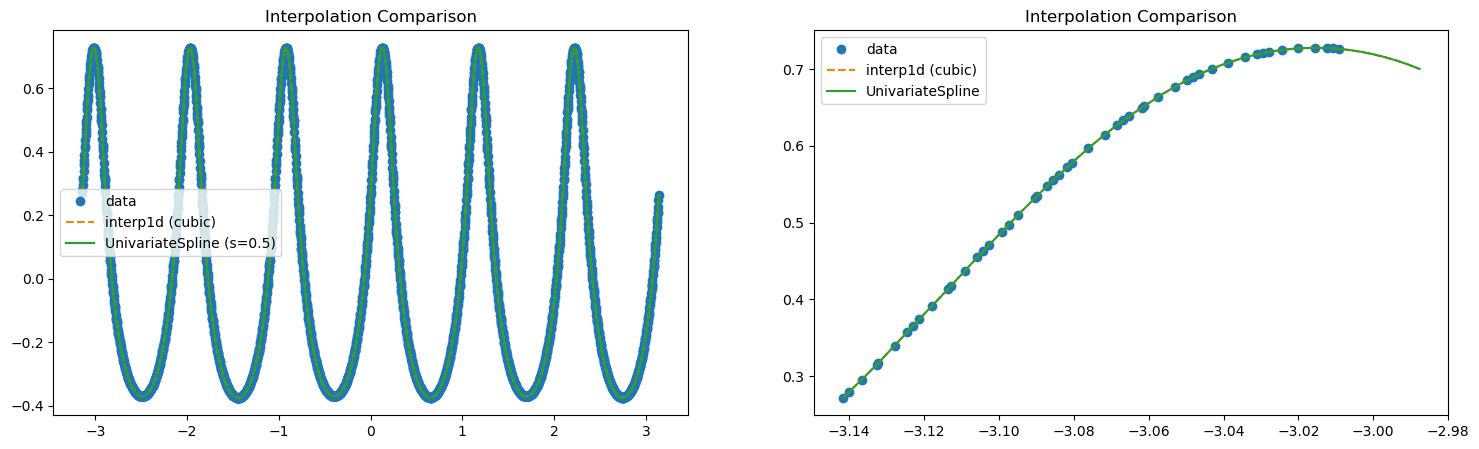

In [ ]:
"""Comparison of interpolation scemes
"""
# Noisy data
x = theta
y = r_fluc

x_dense = np.linspace(x[0], x[-1], 2000)

# Exact interpolation (will follow noise)
f_interp = interp1d(x, y, kind='slinear')(x_dense)

# Smooth spline interpolation
f_spline = UnivariateSpline(x, y, s=1e-10)(x_dense)

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
axes[0].plot(x, y, 'o', label='data')
axes[0].plot(x_dense, f_interp, label='interp1d (cubic)', linestyle='--')
axes[0].plot(x_dense, f_spline, label='UnivariateSpline (s=0.5)', linestyle='-')
axes[0].legend()
axes[0].set_title("Interpolation Comparison")

axes[1].plot(x[:50], y[:50], 'o', label='data')
axes[1].plot(x_dense[:50], f_interp[:50], label='interp1d (cubic)', linestyle='--')
axes[1].plot(x_dense[:50], f_spline[:50], label=f'UnivariateSpline', linestyle='-')
axes[1].legend()
axes[1].set_title("Interpolation Comparison")
plt.show()

['01.00_01', '01.25_03', '01.30_01', '01.3125_03', '01.375_02', '01.50_02', '01.50_03', '01.75_01', '01.75_08', '02.00_02', '02.00_05', '02.00_06', '02.05_01', '02.10_01', '02.15_01', '02.20_01', '02.25_02', '02.25_04', '02.30_02', '02.35_01', '02.50_02', '02.75_08']


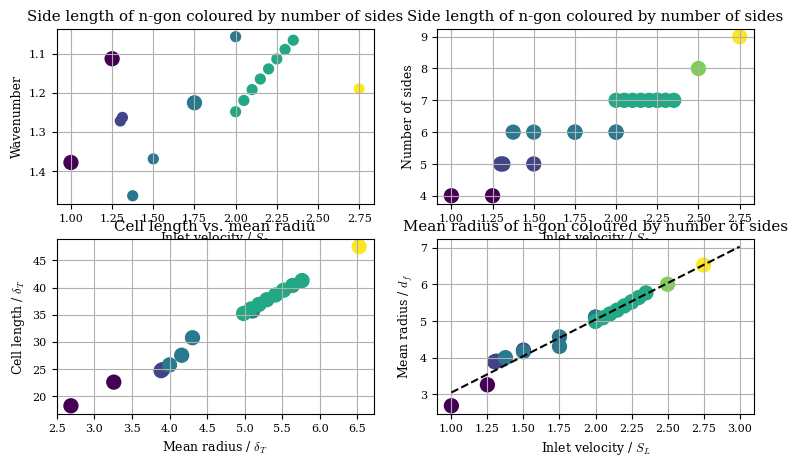

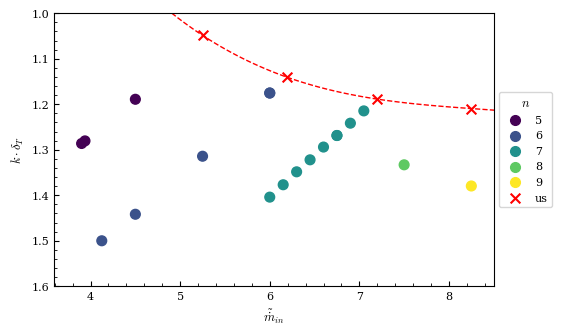

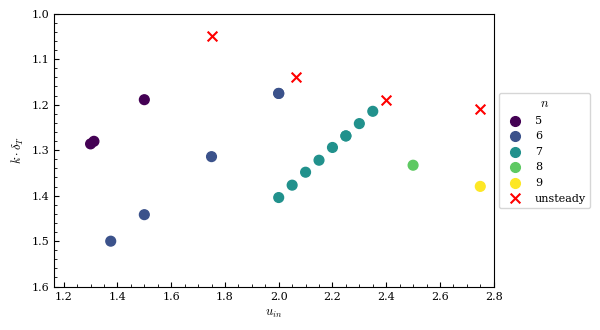

In [ ]:
username = os.getlogin()
case = 'base_18.4k_phi_0.6'

unstable_runs = ["02.40_01", "02.75_03", "02.0625_01", "01.75_02"]
us_runs_times = [100, 49, 50, 40]

dataset_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results")
case_dir = dataset_dir / case

cases_df = get_cases(case, 'is_stable')
stable_runs = [f"{u_in}_{int(run):02d}" for u_in, run in zip(cases_df['u_in'], cases_df['run'])]    #  create list from dataframes
circle_df = cases_df[cases_df['circ_cont'] == 'x']
is_cs = (cases_df['circ_cont'] == 'x').to_numpy()
is_norm_r = (cases_df['R_in'] == '3').to_numpy()

print(stable_runs)
def get_steady_state_properties(run_list, case_dir, time_list=None):
    length_sides = []
    num_sides = []
    inlet_vels = []
    r_means = []
    amp_hightones = []
    for i, run in enumerate(run_list):
        u_in, run_num = run.split("_")
        run_dir = case_dir / f"Uin_{u_in}_RUN{run_num}"

        
        # find the Isocontour file with the latest time
        db_files_dir = run_dir / "database"
        all_files = os.listdir(db_files_dir)

        # Filter files that match the pattern and extract time
        matches = []
        for f in all_files:
            match = re.match(r"Isotherm_T_3_t_(\d+)", f)
            if match:
                time_val = int(match.group(1))
                matches.append((f, time_val))

        # Find the file with the largest time
        if matches:
            if time_list is None:
                final_Isocon = max(matches, key=lambda x: x[1])[0]
            else:
                time = time_list[i]
                matching_files = [f for f, t in matches if t == time]
                if matching_files:
                    final_Isocon = matching_files[0]
                else:
                    raise ValueError(f"No Isotherm file found for time {time} in {db_files_dir}")
        else:
            print("[WARNING] No matching files found.")
        filepath = db_files_dir / final_Isocon
        df = extract_fields_from_okc(filepath, ['x', 'y', 'x_velocity', 'y_velocity'])
        theta_unsorted, r_mean, r_fluc_unsorted = cartesian_df_to_polar(df)
        #velocity_mag_unsorted = np.sqrt(df['x_velocity'].to_numpy() ** 2 + df['y_velocity'].to_numpy() ** 2)

        # Get the indices that would sort theta
        sorted_indices = np.argsort(theta_unsorted)
        theta = theta_unsorted[sorted_indices]
        r_fluc = r_fluc_unsorted[sorted_indices]
        
        _num_sides = get_dominant_mode(theta, r_fluc)

        _, amplitudes = interpolated_spline_FFT(theta, r_fluc)
        ind_hightones = [i * _num_sides for i in range(1, 5)]
        amp_hightones.append(amplitudes[ind_hightones])
        num_sides.append(_num_sides)
        inlet_vels.append(float(u_in)) 
        #df = extract_fields_from_okc(run_dir, ['x', 'y', 'x_velocity', 'y_velocity'])
        filepath = run_dir / "timeseries_T_3_meanvel_len.csv"
        timeseries = pd.read_csv(filepath, sep=r'\s+')
        total_length = float(timeseries['total_length'].iloc[-1])
        length_sides.append(total_length / max(_num_sides, 1))
        r_means.append(r_mean)

    length_sides = np.array(length_sides)
    num_sides = np.array(num_sides)
    inlet_vels =np.array(inlet_vels)
    r_means = np.array(r_means)
    amp_hightones = np.array(amp_hightones)
    return inlet_vels, num_sides, length_sides, r_means, amp_hightones

ss_uin, ss_num_sides, ss_len_sides, ss_r_means, ss_amp_ht = get_steady_state_properties(stable_runs, case_dir)
us_uin, us_num_sides, us_len_sides, us_r_means,_ = get_steady_state_properties(unstable_runs, case_dir, us_runs_times)
sorted_indices = np.argsort(us_uin)
us_mdot = us_uin[sorted_indices] * 3
us_k = us_num_sides[sorted_indices] / us_r_means[sorted_indices]
#print(ss_amp_ht)

# Define shared color range
vmin = 4 #ss_num_sides.min()
vmax = 9 #ss_num_sides.max()
cm = 'viridis'
fig, axes = plt.subplots(2, 2, figsize=(9, 5))

axes[0, 0].scatter(ss_uin[is_cs], 2 * np.pi /ss_len_sides[is_cs], c=ss_num_sides[is_cs], cmap=cm,
                   vmin=vmin, vmax=vmax, s=100, marker='o', label='Start from circle')
axes[0, 0].scatter(ss_uin[~is_cs], 2 * np.pi / ss_len_sides[~is_cs], c=ss_num_sides[~is_cs], cmap=cm,         
                   vmin=vmin, vmax=vmax, s=50, marker='o', label='Used restart')
#axes[0, 0].scatter(inlet_vels_us, tot_length_us/num_sides_us, c=num_sides_us, cmap='tab10',         vmin=vmin, vmax=vmax, s=100, marker='x', label='Unstable')
axes[0, 0].set_xlabel("Inlet velocity / $S_L$")
axes[0, 0].set_ylabel("Wavenumber")
axes[0, 0].invert_yaxis()
axes[0, 0].set_title("Side length of n-gon coloured by number of sides")
#axes[0, 0].set_ylim(4, 8)
#axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].scatter(ss_uin, ss_num_sides, c=ss_num_sides, cmap=cm, vmin=vmin, vmax=vmax, s=100, marker='o')
axes[0, 1].set_xlabel("Inlet velocity / $S_L$")
axes[0, 1].set_ylabel("Number of sides")
axes[0, 1].set_title("Side length of n-gon coloured by number of sides")
#axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].scatter(ss_r_means, ss_len_sides * ss_num_sides, c=ss_num_sides, cmap=cm, vmin=vmin, vmax=vmax, s=100, marker='o')
#axes[1, 0].scatter(inlet_vels_us, tot_length_us, c=num_sides_us, cmap='tab10', s=100, marker='x')
axes[1, 0].set_xlabel(r"Mean radius / $\delta_T$")
axes[1, 0].set_ylabel(r"Cell length / $\delta_T$")
axes[1, 0].set_title("Cell length vs. mean radiu")
#plt.legend()
axes[1, 0].grid(True)
# res = linregress(ss_uin, ss_num_sides * ss_len_sides)
# x_fit = np.linspace(1.25, 3.0, 100)
# y_fit = res.slope * x_fit + res.intercept
# y_pred = 3 * x_fit
# axes[1, 0].plot(x_fit, y_fit, color='black', label='Fit', linestyle='--')
# print(res.slope, res.intercept)

axes[1, 1].scatter(ss_uin, ss_r_means, c=ss_num_sides, cmap=cm, vmin=vmin, vmax=vmax, s=100, marker='o')
axes[1, 1].set_xlabel("Inlet velocity / $S_L$")
axes[1, 1].set_ylabel("Mean radius / $d_f$")
axes[1, 1].set_title("Mean radius of n-gon coloured by number of sides")
# axes[1, 1].legend()
axes[1, 1].grid(True)
res = linregress(ss_uin, ss_r_means)
x_fit = np.linspace(1.00, 3.0, 100)
y_fit = res.slope * x_fit + res.intercept
y_pred = 3 * x_fit
axes[1, 1].plot(x_fit, y_fit, color='black', label='Fit', linestyle='--')
# print(res.slope, res.intercept)

plt.show()


def predict_shape(u_in, slope, intercept):
    l_tot_pred = u_in * slope + intercept
    num_sides = []
    l_sides = []
    for num_side in range(4,10):
        l_side = l_tot_pred / num_side
        if l_side > 5.8 and l_side < 6.8:
            num_sides.append(num_side)
            l_sides.append(l_side)
    print(num_sides)
    print(l_sides)

vmin = 5 #ss_num_sides.min()
vmax = 9 #ss_num_sides.max()
cm = 'viridis'

fig, ax1 = plt.subplots(figsize=(w_plot_mw, h_plot_mw))
ax1.scatter(ss_uin[is_norm_r] * 3, ss_num_sides[is_norm_r] / ss_r_means[is_norm_r], c=ss_num_sides[is_norm_r], cmap=cm,         
            vmin=vmin, vmax=vmax, s=49, marker='o')
ax1.scatter(us_uin * 3, us_num_sides / us_r_means, c='r',         
            s=49, marker='x')
# create a Bspline for the critical wavenumber
uin_Bspline = np.linspace(4, 10, 100) 
Bspline = UnivariateSpline(us_mdot, us_k, s=0)
k_crit_Bspline = Bspline(uin_Bspline)

ax1.plot(uin_Bspline, k_crit_Bspline, linestyle='--', c='r', linewidth=1.0)
# Fake points to create legend; needs the ylim(...) to avoid being plotted
for i in range(5, max(ss_num_sides) + 1):
    ax1.scatter([4], [5], c=i, cmap=cm,         
            vmin=vmin, vmax=vmax, s=49, marker='o', label=f"{i}")
ax1.scatter([4], [5], c='r',         
            s=49, marker='x', label=r'us')
ax1.set_xlabel(r'$\tilde{\dot{m}}_{in}$')
ax1.set_ylabel(r'$k \cdot \delta_T$')
ax1.invert_yaxis()
ax1.tick_params(axis='both', which='both', labelcolor='black', direction='in')
ax1.minorticks_on()
ax1.set_ylim(bottom=1.6, top=1.0)
ax1.set_xlim(right=8.5)
ax1.grid(False)
ax1.legend(title="$n$", loc="center left", bbox_to_anchor=(1, 0.5))
fig.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Comparisons/sstate_cell_sizes_Ri3.png"
                    , dpi=300,bbox_inches='tight')

In [ ]:
def extract_fourier_modes(run_list, case_dir, num_modes = 50, nu_res = 1, method='both'):
    """
    Input:
        run_list:       list: runs with format <u_in>_<run_number>
        case_dir:       str: directory to the casefiles e.g .../sim_results/base_18.4k_phi_0.6
        num_modes:      int: number of first modes to output (exluding the 0 mode)
        nu_res:         int: resolution factor for non-uniform sampling (broken with least squares)
        method:         str: method of calculating the modes; fft - use fast fourier transform; ls - use least squares; both - use both

    Output:
        scalars_arr     array(timesteps x 4): Array of scalars at each timestep; col 1 - time, col 2 - mean velocity magnitude; col 3 - length of isotherm; col 4 - mean radius
        amp_tot         array(timesteps x num_modes): Array of the amplitude of fourier coeffs for the modes - from FFT
        k_tot           array(timesteps x num_modes): Array of the wavenumber of the modes - from FFT
        amp_ni_tot      array(timesteps x num_modes): Array of the amplitude of fourier coeffs for the modes - from least squares
        k_ni_tot        array(timesteps x num_modes): Array of the wavenumber of the modes - from least squares

    """
    scalars_arr_list =  []
    amp_arr_list =      []
    k_arr_list =        []
    amp_ni_arr_list =   []
    k_ni_arr_list =     []
    for run in run_list:   
        # Set directories of run
        u_in, run_num = run.split("_")
        run_dir = case_dir / f"Uin_{u_in}_RUN{run_num}"
        db_files_dir = run_dir / "database"

        # Extract the timesteps and scalar values from the csv file
        filepath = run_dir / "timeseries_T_3_meanvel_len.csv"
        timeseries = pd.read_csv(filepath, skipinitialspace=True)
        timeseries.columns = timeseries.columns.str.strip()
        num_files = len(timeseries)
        
        # initialize data arrays
        scalars_arr = np.empty((num_files, 4))
        scalars_arr[:,0] = timeseries['time'].to_numpy()
        scalars_arr[:,1] = 0.0 #timeseries['v_mag_mean'].to_numpy()
        scalars_arr[:,2] = timeseries['total_length'].to_numpy()

        amp_arr     = np.empty((num_files, num_modes))
        k_arr       = np.empty((num_files, num_modes))
        amp_ni_arr  = np.empty((num_files, num_modes * nu_res))
        k_ni_arr    = np.empty((num_files, num_modes * nu_res))

        db_files = [f"Isotherm_T_3_t_{time:.2f}.okc" for time in scalars_arr[:,0]]

        if method == 'both' or method == 'fft':
            for i, file in enumerate(db_files):
                filepath = db_files_dir / file
                # Read the file
                df = extract_fields_from_okc(filepath, ['x', 'y', 'x_velocity', 'y_velocity'])
                theta_unsorted, r_mean, r_fluc_unsorted = cartesian_df_to_polar(df)
                scalars_arr[i,3] = r_mean
                
                # Sort arrays by theta
                sorted_indices = np.argsort(theta_unsorted)
                theta = theta_unsorted[sorted_indices]
                r_fluc = r_fluc_unsorted[sorted_indices]
                
                # Perform spatial FFT on the real length data
                r_fluc_k_r, r_fluc_amp_r = interpolated_spline_FFT(theta * r_mean, r_fluc, n_modes=num_modes+1)
                amp_arr[i] = r_fluc_amp_r[1:num_modes+1]
                k_arr[i,:] = r_fluc_k_r[1:num_modes+1]

        if method == 'both' or method == 'ls':
            for i, file in enumerate(db_files):
                filepath = db_files_dir / file
                # Read the file
                df = extract_fields_from_okc(filepath, ['x', 'y'])
                theta_unsorted, r_mean, r_fluc_unsorted = cartesian_df_to_polar(df)
                if method != 'both': scalars_arr[i,3] = r_mean

                # Sort arrays by theta
                sorted_indices = np.argsort(theta_unsorted)
                theta = theta_unsorted[sorted_indices]
                r_fluc = r_fluc_unsorted[sorted_indices]
                
                # Perform least squares with cosine basis functions
                modes_non_fixed = np.linspace(1 / nu_res, num_modes, nu_res * num_modes)
                k_smooth, amp_smooth = least_squares_fit(theta, r_fluc, modes=modes_non_fixed, r_mean=r_mean)
                amp_ni_arr[i] = np.abs(amp_smooth)
                k_ni_arr[i] = k_smooth

        # Create list from all run arrays
        scalars_arr_list.append(scalars_arr)
        amp_arr_list.append(amp_arr)
        k_arr_list.append(k_arr)
        amp_ni_arr_list.append(amp_ni_arr)
        k_ni_arr_list.append(k_ni_arr)

    # Concatenate arrays into one
    scalars_tot = np.concatenate(scalars_arr_list)
    amp_tot = np.concatenate(amp_arr_list)
    k_tot = np.concatenate(k_arr_list)
    amp_ni_tot = np.concatenate(amp_ni_arr_list)
    k_ni_tot = np.concatenate(k_ni_arr_list)
    return scalars_tot, amp_tot, k_tot, amp_ni_tot, k_ni_tot

def plot_growth_exp_timeseries(t, k, amp, l_slice, modes, t_max):
    my_cmap = plt.get_cmap('nipy_spectral')
    colors = my_cmap(np.linspace(0, 1, len(modes)))
    plt.figure(figsize=(9, 5))
    for i, mode in enumerate(modes):
        slopes_arr = np.empty(len(t)-l_slice)
        for j in range(len(t)- l_slice):
            t_window = t[j:(j + l_slice)]
            log_amp_window = np.log(amp[j:(j + l_slice), mode-1])
            slope, intercept, r_value, p_value, std_err = linregress(t_window, log_amp_window)
            slopes_arr[j] = slope
        plt.plot(t[:len(t)-l_slice], slopes_arr, color=colors[i], label=str(mode), linewidth=0.8)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Time series of growth rates')
    plt.ylim(bottom = -0.5, top = 1)
    plt.xlim(left = 0, right = t_max)
    plt.grid(True)
    plt.legend(prop={'size': 6})
    plt.show()

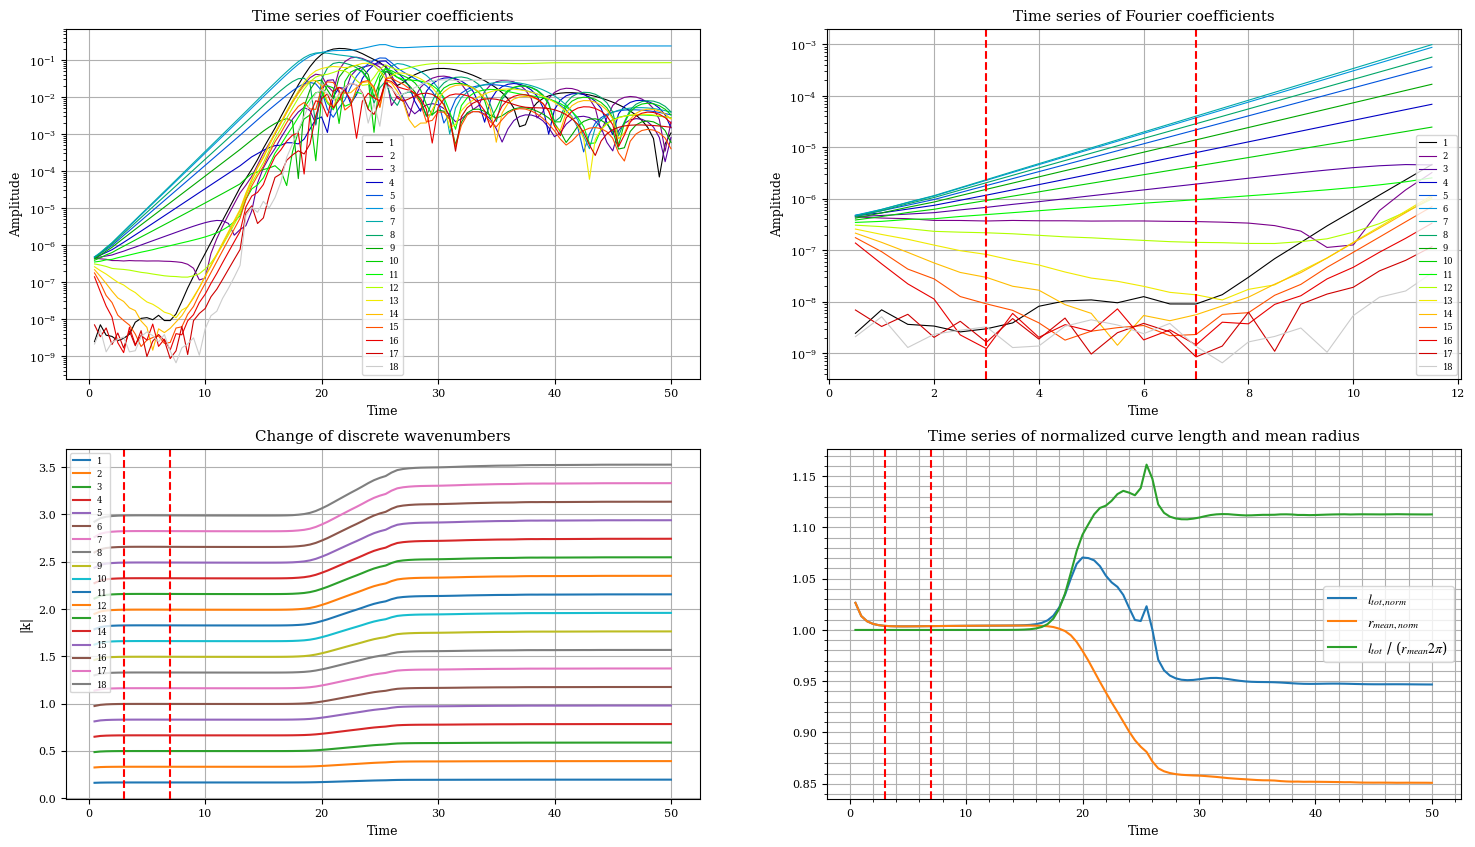

In [ ]:
"""Perform extended FFT analysis for a list of runs (consecutive)"""
username = os.getlogin()
case1 = "base_18.4k_phi_0.6"
case1 = "disp_1atm_phi_0.6"
runs = ["02.00_05"]
dataset_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results")
case_dir = dataset_dir / case1
scalars_tot, amp_tot, k_tot, amp_ni_tot, k_ni_tot = extract_fourier_modes(runs, case_dir, num_modes=100, nu_res=1)
# Extract dispersion relation
plt_s = slice(0, 18)
#modes = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12 ,13] # Mode [n_min-1, m_max
modes = list(range(2, 7))
t_start = 3
t_end = 7
t_start_ind = np.argmin(np.abs(scalars_tot[:,0] - t_start))
t_end_ind = np.argmin(np.abs(scalars_tot[:,0] - t_end))

my_cmap = plt.get_cmap('nipy_spectral')
colors = my_cmap(np.linspace(0, 1, (plt_s.stop - plt_s.start)))


# Plot whole time series of fourier coefficients
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
for i in range(plt_s.start, plt_s.stop):
    axes[0, 0].semilogy(scalars_tot[:,0], amp_tot[:,i], color=colors[i-plt_s.start], label=str(i+1), linewidth=0.8)
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].set_title('Time series of Fourier coefficients')
axes[0, 0].grid(True)
axes[0, 0].legend(prop={'size': 6})

# Plot narrowed range to show linear growth better
for i in range(plt_s.start, plt_s.stop):
    axes[0, 1].semilogy(scalars_tot[max(0, int(t_start_ind)-20):t_end_ind+10,0], amp_tot[max(0, int(t_start_ind)-20):t_end_ind+10,i], color=colors[i-plt_s.start], label=str(i+1), linewidth=0.8)
axes[0, 1].axvline(x=t_start, color='red', linestyle='--')
axes[0, 1].axvline(x=t_end, color='red', linestyle='--')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Amplitude')
axes[0, 1].set_title('Time series of Fourier coefficients')
axes[0, 1].grid(True)
axes[0, 1].legend(prop={'size': 6})

# Plot change of noninteger wavenumber
#axes[1, 0].plot(scalars_tot[:,0], k_ni_tot[:,plt_s.start:plt_s.stop])
axes[1, 0].plot(scalars_tot[:,0], k_tot[:,plt_s.start:plt_s.stop])
axes[1, 0].axvline(x=t_start, color='red', linestyle='--')
axes[1, 0].axvline(x=t_end, color='red', linestyle='--')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('|k|')
axes[1, 0].set_title('Change of discrete wavenumbers')
axes[1, 0].grid(True)
axes[1, 0].legend([str(i+1) for i in range(plt_s.start, plt_s.stop)], prop={'size': 6})

# Plot total length (inverse prop. to |k|)
#r_init = scalars_tot[0,3]
r_init = 6.0
l_init = r_init * 2 * np.pi
axes[1, 1].plot(scalars_tot[:,0], scalars_tot[:,2] / l_init, label='$l_{tot,norm}$')
axes[1, 1].plot(scalars_tot[:,0], scalars_tot[:,3] / r_init, label='$r_{mean,norm}$')
axes[1, 1].plot(scalars_tot[:,0], scalars_tot[:,2] / (scalars_tot[:,3] * 2 * np.pi), label=r'$l_{tot}$ / ($r_{mean} 2 \pi$)')
axes[1, 1].axvline(x=t_start, color='red', linestyle='--')
axes[1, 1].axvline(x=t_end, color='red', linestyle='--')
axes[1, 1].set_title('Time series of normalized curve length and mean radius')
axes[1, 1].set_xlabel('Time')
axes[1, 1].minorticks_on()
axes[1, 1].grid(True, which='both')
axes[1, 1].legend(prop={'size': 10})
plt.show()


NameError: name 'plt_s' is not defined

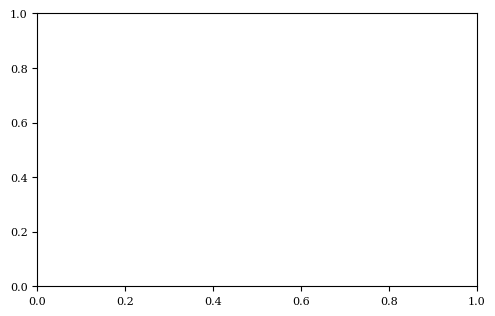

In [ ]:
fig, ax = plt.subplots(figsize=(w_plot_mw, h_plot_mw))
my_cmap = plt.get_cmap('viridis')
colors = my_cmap(np.linspace(0, 1, (plt_s.stop - plt_s.start)))
rect = patches.Rectangle((3.0, 0.0), 4.0, 1.0, edgecolor="none", facecolor=colors_l[1], alpha=0.2)
ax.add_patch(rect)
for i in range(plt_s.start, plt_s.stop):
    ax.semilogy(scalars_tot[max(0, int(t_start_ind)-20):t_end_ind+37,0], amp_tot[max(0, int(t_start_ind)-20):t_end_ind+37,i], color=colors[i-plt_s.start], label=str(i+1), linewidth=0.8)
ax.set_xlabel(r'$t \,/ \, \tau_f$')
ax.set_ylabel(r'$A_n \, / \, \delta_T$', labelpad=-2)
ax.tick_params(axis='both', which='both', labelcolor='black', direction='in')
ax.minorticks_on()
ax.margins(x=0)
ax.set_ylim(top=1, bottom=1.0e-10)
ax.legend(title=r'$n$', loc="center left", bbox_to_anchor=(1, 0.5), fontsize=6)
fig.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Disp_rels/Example_02.00_05_growthrate.png", 
            dpi=300, bbox_inches='tight')

In [ ]:
plot_growth_exp_timeseries(scalars_tot[:,0], k_tot, amp_tot, 3, modes, 50)
# meanvel; ltot; rmean
print(f"{scalars_tot[-1,1]}\t{scalars_tot[-1,2]}\t{scalars_tot[-1,3]}")

NameError: name 'scalars_tot' is not defined

In [71]:
def get_growth_exp(t, k, amp, time_slice, modes, output='terminal'):
    """ Function to calculate exponential growth exponent omega in amp(t) ~ C * exp(omega * t)
    Input
        t:      array of timesteps where k and amp where calculated
        k:      array of wavenumbers with dimension (len(t), >max(modes))
        amp:    array of fourier coeff. amplitude, same dimension as k
        modes:  list of mode number where growth exponent should be evaluated
        output: mode of output for individual values (terminal -> print output)
    Output
        slopes_arr: array of omegas with len(modes)
        k_mean_arr: array of mean wavenumber over time with len(modes)
    """
    # Get indices from times and slice the input arrays
    t_start_ind = np.argmin(np.abs(t - time_slice[0]))
    t_end_ind = np.argmin(np.abs(t - time_slice[1]))
    sliced_amp = amp[t_start_ind:t_end_ind]
    sliced_k = k[t_start_ind:t_end_ind]
    sliced_t = t[t_start_ind:t_end_ind]

    # Get the logarithm of the amplitude and prepare output arrays
    log_amp = np.log(sliced_amp)
    slopes_arr = np.empty((len(modes)))
    k_mean_arr = np.empty((len(modes)))

    # Loop over all timesteps to get growthrate and mean wavenumber
    for i, mode in enumerate(modes):
        slope, intercept, r_value, p_value, std_err = linregress(sliced_t, log_amp[:, mode-1])
        k_mean = np.mean(sliced_k[:, mode-1])
        k_rel_change = (sliced_k[-1, mode-1] - sliced_k[0, mode-1]) / sliced_k[0, mode-1]
        if output == 'terminal':
            print(f"{mode}\t{slope:.3f}\t{k_mean:.3f}\t{abs(k_rel_change):.4f}\t{(r_value ** 2):.4f}")
        slopes_arr[i] = slope # type: ignore
        k_mean_arr[i] = k_mean
    return slopes_arr, k_mean_arr

def plot_growth_exp(omega_list, k_list, labels, ylims=(-0.1, 1.0), plot_dims=(w_plot_mw, h_plot_mw), colors=None, ax1=None):
    """ Function to plot the growth exponents over the wavenumber to get the linear dispersion curve
    Input:
        omega_list:     list of arrays containing the growth exponents (array from get_growth_exponent(...))
        k_list:         list of arrays containing the mean wavenumbers
        labels:         list of lables for each run
        title:          str: title of plot
        The each entry in the lists should contain the results from one run, len(lists) = no. of runs, 
        The arrays omega and k must have the same length per run
    """
    if colors is None:
        my_cmap = plt.get_cmap('viridis')
        vmin = 0 
        vmax = len(k_list) - 1
        colors = my_cmap(np.linspace(0, 1.0, len(k_list)))

    # Initialize plot
    if ax1 is None:
        fig, ax1 = plt.subplots(figsize=plot_dims)
        
    # Check if there is a omega and k for each run
    if len(omega_list) != len(k_list):
        raise ValueError("shapes of omega and k does not match")

    # Iterate though all runs
    ax1.axhline(0, color='black', linewidth=1)
    i = 0
    for omega, k in zip(omega_list, k_list):
        # create spline to show interpolated
        k_Bspline = np.linspace(k[0] - 0.2, k[-1] + 0.2, 100) 
        Bspline = UnivariateSpline(k, omega, s=0.1)
        omega_Bspline = Bspline(k_Bspline)
        # k_spline = np.linspace(k[0], k[-1], len(omega)*5)
        # spline = interp1d(k, omega, kind='cubic')
        # omega_interp = spline(k_spline)

        # plot actual values and spline
        ax1.plot(k_Bspline, omega_Bspline, linestyle='--', c=colors[i], linewidth=1.0)
        if labels is None: ax1.scatter(k, omega, s=25, edgecolor=colors[i], marker=markers[i], facecolor='none')
        else:              ax1.scatter(k, omega, label=labels[i], s=25, edgecolor=colors[i], marker=markers[i], facecolor='none')
        # ax1.plot(k_spline, omega_interp, linestyle='--', c=colors[i], linewidth=0.8) 
        i += 1
        
    # Format the plot
    ax1.set_xlabel(r'$k\cdot \delta_T$')
    ax1.set_ylabel(r'$\omega \cdot \tau_f$')
    ax1.set_xlim(left = 0, right= 2.2)
    ax1.set_ylim(ylims)
    if labels is not None: ax1.legend(title=r'$\kappa_{m} \cdot \delta_T$', frameon=True)
    ax1.tick_params(axis='both', which='both', labelcolor='black', direction='in')
    ax1.minorticks_on()
    ax1.grid(False, which='both')
    return ax1

def get_mean_curvature(t, r, time_slice):
    t_start_ind = np.argmin(np.abs(t - time_slice[0]))
    t_end_ind = np.argmin(np.abs(t - time_slice[1]))
    sliced_r = r[t_start_ind:t_end_ind]
    r_mean = np.mean(sliced_r)
    return -1 / r_mean

def get_k_max(omega_list, k_list, r_mean=1):
    k_max = np.empty(len(omega_list))
    omega_max = np.empty(len(omega_list))
    for i in range(len(omega_list)):
        k_Bspline = np.linspace(k_list[i][0] - 0.2, k_list[i][-1] + 0.2, 10000) 
        Bspline = UnivariateSpline(k_list[i], omega_list[i], s=0.1)
        omega_Bspline = Bspline(k_Bspline)
        k_max[i] = k_Bspline[np.argmax(omega_Bspline)]
        omega_max[i] = np.max(omega_Bspline)
        roots = Bspline.roots()
    return k_max, omega_max, k_max * r_mean

def get_k_crit(omega_list, k_list):
    #k_max = np.empty(len(omega_list))
    #omega_max = np.empty(len(omega_list))
    for i in range(len(omega_list)):
        k_Bspline = np.linspace(k_list[i][0] - 0.2, k_list[i][-1] + 0.2, 10000) 
        Bspline = UnivariateSpline(k_list[i], omega_list[i], s=0.1)
        omega_Bspline = Bspline(k_Bspline)
        #k_max[i] = k_Bspline[np.argmax(omega_Bspline)]
        #omega_max[i] = np.max(omega_Bspline)
        roots = Bspline.roots()
        print(i, roots)
    return 
# print("Mean radius: ", np.mean(scalars_tot[t_start_ind:t_end_ind,3]))


# omega_disp, k_disp = get_growth_exp(scalars_tot[:,0], k_tot, amp_tot, [t_start, t_end], modes)
# omega_disp_ls, k_disp_ls = get_growth_exp(scalars_tot[:,0], k_ni_tot, amp_ni_tot, [t_start, t_end], modes, output= 'None')
# plot_growth_exp([omega_disp, omega_disp_ls], [k_disp, k_disp_ls], ['FFT', 'Least squares'])

In [62]:
username = os.getlogin()
filepath = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results")
runs_csv_dir = filepath / "caselist_post_proc.csv"
runs_df = pd.read_csv(runs_csv_dir, dtype=str)
# filter runs for the ones needed here
run_disp = runs_df[runs_df['run_disp'] == 'x']
run_legacy = runs_df[runs_df['run_disp'] == 'l']
disp_phi06 = run_disp[run_disp['case'] == 'disp_1atm_phi_0.6']
disp_phi075 = run_disp[run_disp['case'] == 'disp_1atm_phi_0.75']
le1_phi075 = get_cases('base_18.4k_phi_0.6', 'run_disp')   #run_disp[run_disp['case'] == 'le1_18.4k_phi_0.75']
    
case_rin3_phi06 = disp_phi06[disp_phi06['R_in'] == '3']
#def plot_case_dispersion(case_df, filepath):
    #print(case_df)
case_df = case_rin3_phi06
def calculate_disp_rels(cases_dataframe, filepath):
    omega_disp_list = [np.empty] * len(cases_dataframe)
    k_disp_list = [np.empty] * len(cases_dataframe)
    labels = []
    curvature = []
    ss_points_list = []
    r_mean_list = []
    for i, row in enumerate(cases_dataframe.itertuples(index=False)):
        # convert from row
        case = row.case
        u_in = row.u_in
        run = row.run
        mode_start, mode_stop = map(int, str(row.disp_modes).split("_"))
        modes = list(range(mode_start, mode_stop + 1))
        t_start, t_stop = map(float, row.disp_times.split("_"))
        runs = [f"{u_in}_{int(run):02d}"]
        case_dir = filepath / case
        #print(case_dir, runs)
        scalars_tot, amp_tot, k_tot, amp_ls_tot, k_ls_tot = extract_fourier_modes(runs, case_dir, num_modes=mode_stop + 1, method='fft')
        omega_disp_list[i], k_disp_list[i] = get_growth_exp(scalars_tot[:,0], k_tot, amp_tot, [t_start, t_stop], modes, output='none')
        # calculate mean curvature
        kappa = get_mean_curvature(scalars_tot[:,0], scalars_tot[:,3], [t_start, t_stop])
        #labels.append(f"{kappa:.1e}")
        labels.append(f"{kappa:.2g}")
        r_mean_list.append(-1 / kappa)
        curvature.append(kappa)
        if pd.notna(row.ss_num_cells):
            ss_points_list.append(np.array([kappa * float(row.ss_num_cells), kappa]))
    if len(ss_points_list) != 0: 
        ss_points = np.column_stack(ss_points_list)
    return omega_disp_list, k_disp_list, labels, curvature, r_mean_list

omega_disp_list_rin3, k_disp_list_rin3, labels_rin3, curvature_list_rin3, r_mean_list_rin3 = calculate_disp_rels(case_rin3_phi06, filepath)

(array([1.12127716, 1.08869817, 1.07492065, 1.07484033, 1.06609529]), array([0.71243687, 0.74324954, 0.76217035, 0.77456635, 0.78246893]), array([6.75205448, 7.37251368, 8.08371512, 8.88900658, 9.61653584]))
(array([1.21672009, 1.15921087]), array([0.47543971, 0.64360843]), array([5.49837552, 6.0702327 ]))


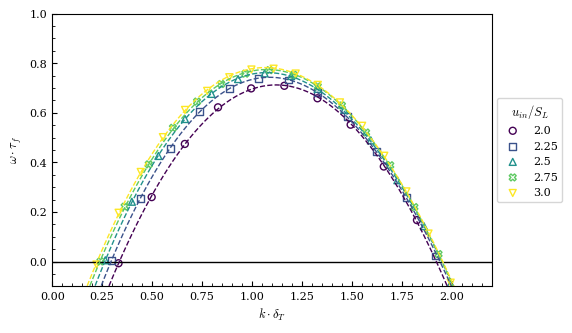

In [72]:
# ax = plot_growth_exp(omega_disp_list_rin3, k_disp_list_rin3, labels_rin3)
ax = plot_growth_exp(omega_disp_list_rin3, k_disp_list_rin3, [2.00, 2.25, 2.50, 2.75, 3.00])
print(get_k_max(omega_disp_list_rin3, k_disp_list_rin3, r_mean_list_rin3))
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), title=r'$u_{in} / S_L$')
plt.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Disp_rels/Disp_rel_Rin3_phi06_sweep.png",
             dpi=300,bbox_inches='tight')
legacy_disp_phi06 = run_legacy[run_legacy['case'] == 'base_18.4k_phi_0.6']
omega_disp_list_rin3_l, k_disp_list_rin3_l, _, _, r_mean_list_rin3_l = calculate_disp_rels(legacy_disp_phi06, filepath)
#ax = plot_growth_exp(omega_disp_list_rin3_l, k_disp_list_rin3_l, labels_rin3_l)
print(get_k_max(omega_disp_list_rin3_l, k_disp_list_rin3_l, r_mean_list_rin3_l))


In [32]:
case_rin1_phi06 = disp_phi06[disp_phi06['R_in'] == '1']
case_rin10_phi06 = disp_phi06[disp_phi06['R_in'] == '10']
omega_disp_list_rin1, k_disp_list_rin1, labels_rin1, curvature_list_rin1, r_mean_list_rin1 = calculate_disp_rels(case_rin1_phi06, filepath)
omega_disp_list_rin10, k_disp_list_rin10, labels_rin10, curvature_list_rin10, r_mean_list_rin10 = calculate_disp_rels(case_rin10_phi06, filepath)

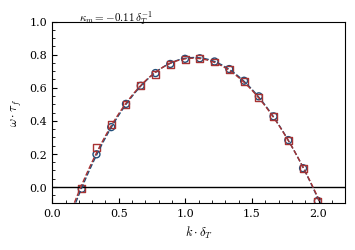

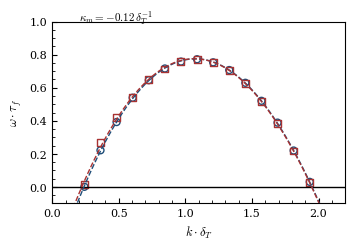

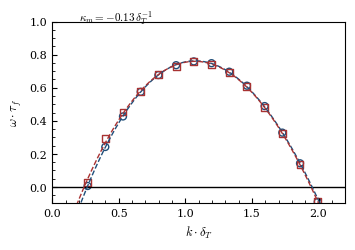

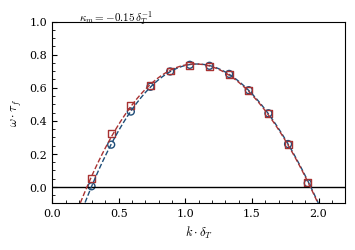

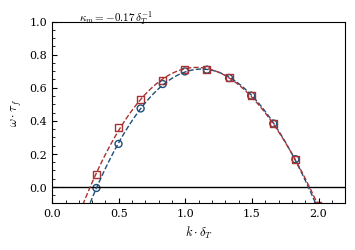

In [33]:
for i in range(5):
    omega_disp_comp = [omega_disp_list_rin3[-1-i], omega_disp_list_rin1[-1-i]]
    k_disp_comp = [k_disp_list_rin3[-1-i], k_disp_list_rin1[-1-i]]
    # labels = [labels_rin1[-1-i], labels_rin3[-1-i]]
    ax = plot_growth_exp(omega_disp_comp, k_disp_comp, None, plot_dims=(w_plot_s, h_plot_s), colors=colors_d)
    ax.text(0.2, 1.0, f"{r'$\kappa_m = '}{labels_rin1[-1-i]}{r'\,\delta_T^{-1}$'}", fontsize=8, fontweight='bold')
    name = f"Disp_rel_Rin_comp_phi06_{i}"
    plt.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Disp_rels/{name}.png",
             dpi=300,bbox_inches='tight')

(array([1.18592058, 1.11632144, 1.10787453, 1.09567587, 1.08316388,
       1.074255  , 1.07185744, 1.06738728, 1.05933913]), array([0.50024116, 0.60963051, 0.66521566, 0.69646086, 0.72262506,
       0.7432817 , 0.75947769, 0.77513836, 0.77835325]), array([3.58975795, 4.21370323, 5.01111393, 5.77804327, 6.5227822 ,
       7.27359096, 8.06158801, 8.82857954, 9.55473258]))
0 [0.11828002 1.96946494]
1 [0.10868311 1.97463319]
(array([1.05118355, 1.04314126]), array([0.84947491, 0.8609239 ]), array([1.05118355, 1.04314126]))


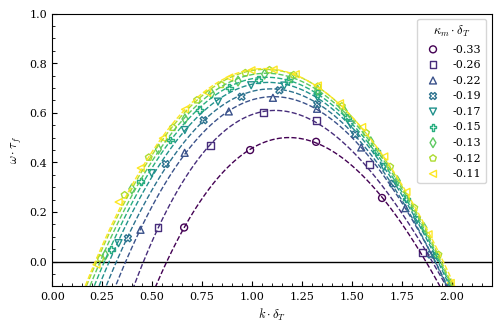

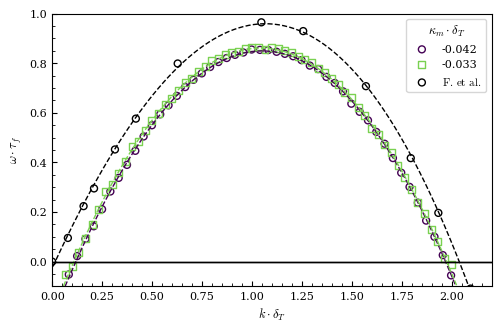

In [ ]:
ax = plot_growth_exp(omega_disp_list_rin1, k_disp_list_rin1, labels_rin1)[1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75]
df_fz = pd.read_csv(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Additional Data/dispersion060_interp.dat", sep=r'\s+')
#ax = plot_growth_exp([df_fz.iloc[::-1,1].to_numpy()], [df_fz.iloc[::-1,0].to_numpy()], labels=[r'$\text{F. et al.}$'], colors=['k'], ax1=ax)
#ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
print(get_k_max(omega_disp_list_rin1, k_disp_list_rin1, r_mean_list_rin1))
plt.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Disp_rels/Disp_rel_Rin1_phi06_sweep.png",
             dpi=300,bbox_inches='tight')
my_cmap = plt.get_cmap('viridis')
ax = plot_growth_exp(omega_disp_list_rin10, k_disp_list_rin10, labels_rin10, colors=[my_cmap(0), my_cmap(0.8)])
ax = plot_growth_exp([df_fz.iloc[::-1,1].to_numpy()], [df_fz.iloc[::-1,0].to_numpy()], labels=[r'$\text{F. et al.}$'], colors=['k'], ax1=ax)
plt.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Disp_rels/Disp_rel_Rin10_phi06_sweep.png",
             dpi=300,bbox_inches='tight')
get_k_crit(omega_disp_list_rin10, k_disp_list_rin10)
print(get_k_max(omega_disp_list_rin10, k_disp_list_rin10))

In [35]:
runs_csv_dir = filepath / "caselist_post_proc.csv"
runs_df = pd.read_csv(runs_csv_dir, dtype=str)
run_disp = runs_df[runs_df['run_disp'] == 'x']
disp_phi075 = run_disp[run_disp['case'] == 'disp_1atm_phi_0.75']
case_rin1_phi075 = disp_phi075[disp_phi075['R_in'] == '1']
omega_disp_list_phi075, k_disp_list_phi075, labels_phi075, curvature_list_phi75, r_mean_list_phi075 = calculate_disp_rels(case_rin1_phi075, filepath)


(array([1.21061099, 1.16729941, 1.08130506, 1.08451994, 1.0562402 ,
       1.05654008, 1.03981592, 1.02479864]), array([0.22333113, 0.38252995, 0.4646346 , 0.48869754, 0.4952296 ,
       0.50541703, 0.55483138, 0.57422184]), array([3.64864668, 4.39773284, 4.87976581, 5.71704397, 6.36237637,
       7.17476305, 7.83423117, 8.49320899]))
(array([1.23497502, 1.15985663, 1.11741727, 1.08063209, 1.04286141]), array([0.23596863, 0.38769649, 0.46572601, 0.51486009, 0.54714785]), array([5.55409969, 6.0718021 , 6.67920506, 7.26068231, 7.77932589]))


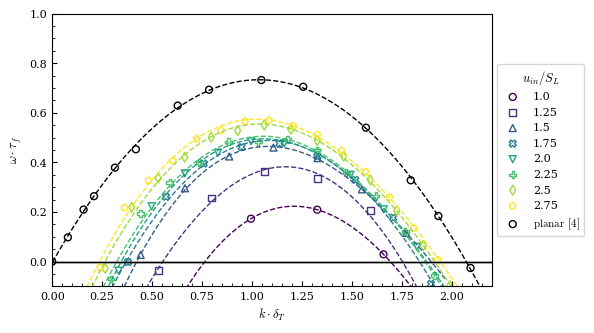

In [69]:
# ax = plot_growth_exp(omega_disp_list_phi075, k_disp_list_phi075,labels_phi075)
ax = plot_growth_exp(omega_disp_list_phi075, k_disp_list_phi075,[1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75])
df_fz = pd.read_csv(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Additional Data/dispersion075.dat", sep=r'\s+')
# ax = plot_growth_exp([df_fz.iloc[::-1,1].to_numpy()], [df_fz.iloc[::-1,0].to_numpy()], labels=[r'$\text{F. et al.}$'], colors=['k'], ax1=ax)
ax = plot_growth_exp([df_fz.iloc[::-1,1].to_numpy()], [df_fz.iloc[::-1,0].to_numpy()], labels=[r'$\text{planar [4]}$'], colors=['k'], ax1=ax)


ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), title=r'$u_{in} / S_L$')
print(get_k_max(omega_disp_list_phi075, k_disp_list_phi075, r_mean_list_phi075))
plt.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Disp_rels/Disp_rel_Rin1_phi075_sweep.png",
             dpi=300,bbox_inches='tight')

legacy_disp_phi075 = run_legacy[run_legacy['case'] == 'base_18.4k_phi_0.75']
omega_disp_list_phi075_l, k_disp_list_phi075_l, labels_phi075_l, _, r_mean_list_phi075_l = calculate_disp_rels(legacy_disp_phi075, filepath)
print(get_k_max(omega_disp_list_phi075_l, k_disp_list_phi075_l, r_mean_list_phi075_l))

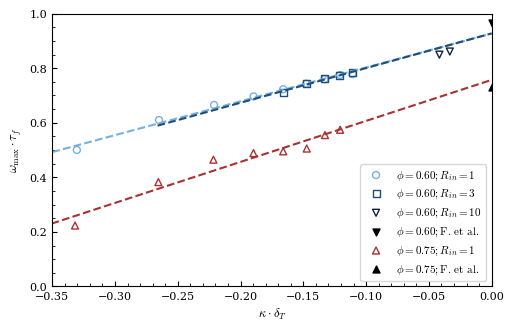

In [ ]:
def plot_k_max_vs_kappa(omega_list, k_list, kappa_list, color='b', ax=None, label=None, marker='o', draw_linreg=True):
    """
    Plot maximum growth rate vs. mean curvature with linear trendline.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(w_plot_mw, h_plot_mw))

    _, omega_max, _ = get_k_max(omega_list, k_list)
    ax.scatter(kappa_list, omega_max, label=label, s=25, edgecolor=color, marker=marker, facecolor='none')

    if draw_linreg:
        # Linear fit
        z = np.polyfit(kappa_list, omega_max, 1)
        p = np.poly1d(z)
        kappa_plt = np.linspace(min(kappa_list)-0.1, 0 , 100)
        ax.plot(kappa_plt, p(kappa_plt), c=color, linestyle='--')

    # Labels and formatting
    ax.set_xlabel(r'$\kappa_m \cdot \delta_T$')
    ax.set_ylabel(r'$\omega_{\max} \cdot \tau_f$')
    ax.set_xlim(left=-0.35, right=0)
    ax.tick_params(axis='both', which='both', labelcolor='black', direction='in')
    ax.minorticks_on()
    ax.grid(False)

    return ax


def plot_interpolated_dispersion(omega_list, k_list, kappa_list, ss_points):
    """
    Interpolated dispersion relations (contour plot with spline).
    """
    # B-spline interpolator
    kappa_arr_list = [np.full(len(k_list[i]), kappa) for i, kappa in enumerate(kappa_list)]
    spline = SmoothBivariateSpline(np.concatenate(kappa_arr_list), 
                                   np.concatenate(k_list), 
                                   np.concatenate(omega_list), 
                                   s=0.1)

    # Grid for evaluation and interpolation
    kappa_grid = np.linspace(min(kappa_list), max(kappa_list), 100)
    k_grid = np.linspace(0, 2.2, 100)
    KAPPA, K = np.meshgrid(kappa_grid, k_grid)
    OMEGA = spline.ev(KAPPA.ravel(), K.ravel()).reshape(KAPPA.shape)

    # Plot
    fig, ax = plt.subplots(figsize=(9, 5))
    vmax = np.max(np.concatenate(omega_list))
    contour = ax.contourf(KAPPA, K, OMEGA, levels=100, cmap='RdBu_r',
                          vmax=vmax, vmin=-vmax)
    cbar = fig.colorbar(contour, ax=ax, label=r'$\omega$')

    # Zero contour line
    ax.contour(KAPPA, K, OMEGA, levels=[0], colors='black', linewidths=1, linestyles='-')

    # Find k_max vs. kappa
    k_max_idx = np.argmax(OMEGA, axis=0)
    k_max_values = k_grid[k_max_idx]
    spline_kmax = UnivariateSpline(kappa_grid, k_max_values, s=0.01)
    kappa_fine = np.linspace(kappa_grid.min(), kappa_grid.max(), 500)
    k_max_smooth = spline_kmax(kappa_fine)

    # Plot line and steady-state points
    ax.plot(kappa_fine, k_max_smooth, color='red', linewidth=1,
            label=r'$k_{\mathrm{max}}$ (max $\omega$)')
    ax.scatter(ss_points[1], ss_points[0])

    ax.set_xlabel(r'$\kappa$')
    ax.set_ylabel(r'$k$')
    ax.set_title('Interpolated dispersion relations')
    ax.legend()
    plt.show()

ax = plot_k_max_vs_kappa(omega_disp_list_rin1, k_disp_list_rin1, curvature_list_rin1,
                         color=colors_l[0], label=r'$\phi = 0.60; R_{in} = 1$', marker=markers[0])
ax = plot_k_max_vs_kappa(omega_disp_list_rin3, k_disp_list_rin3, curvature_list_rin3,
                         color=colors_d[0], ax=ax, label=r'$\phi = 0.60; R_{in} = 3$', marker=markers[1])
ax = plot_k_max_vs_kappa(omega_disp_list_rin10, k_disp_list_rin10, curvature_list_rin10,
                         color="#14213d", ax=ax, label=r'$\phi = 0.60; R_{in} = 10$', marker=markers[4], draw_linreg=False)
ax.scatter(-0.00, 0.965, marker="v", edgecolor='k', facecolor='k', s=25, label=r"$\phi = 0.60;\text{F. et al.}$")
ax = plot_k_max_vs_kappa(omega_disp_list_phi075, k_disp_list_phi075, curvature_list_phi75,
                         color=colors_d[1], ax=ax, label=r'$\phi = 0.75; R_{in} = 1$', marker=markers[2])

ax.scatter(-0.0, 0.732, marker="^", edgecolor='k', facecolor='k', s=25, label=r"$\phi = 0.75;\text{F. et al.}$")
ax.legend(loc="lower right")
ax.set_ylim(bottom=0, top=1.0)
# Put ticks and labels on the right
#ax.yaxis.tick_right()
#ax.yaxis.set_label_position("right")
plt.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Disp_rels/omega_max_comp.png",
            dpi=300,bbox_inches='tight')

In [ ]:
mean_vars = ["s11", "s13", "s19"]
mean_vars_head = [f"{i},   " for i in mean_vars]
print(f'time, v_mag_mean, {*[f"{i},   " for i in mean_vars]}\n')

SyntaxError: can't use starred expression here (1415191690.py, line 3)

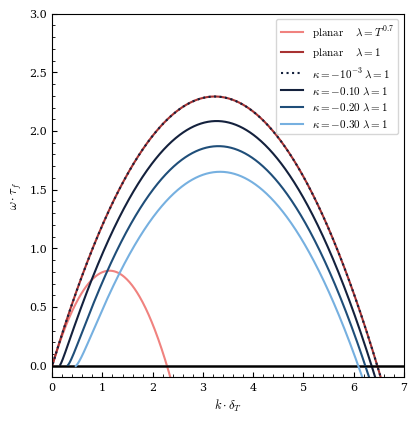

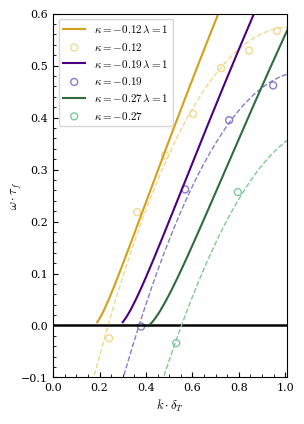

In [47]:
def plot_theo_growth_exp(omega_list, k_list, labels, plot_dims=(w_plot_mw, h_plot_mw), colors=None, ax=None, 
                         k_min=0.0, linestyle='-'):
    """ Function to plot the growth exponents over the wavenumber to get the linear dispersion curve
    Input:
        omega_list:     list of arrays containing the growth exponents (array from get_growth_exponent(...))
        k_list:         list of arrays containing the mean wavenumbers
        labels:         list of lables for each run
        title:          str: title of plot
        The each entry in the lists should contain the results from one run, len(lists) = no. of runs, 
        The arrays omega and k must have the same length per run
    """
    ylims=(-0.1, 3.0)
    if colors is None:
        my_cmap = plt.get_cmap('viridis')
        vmin = 0 
        vmax = len(k_list) - 1
        colors = my_cmap(np.linspace(0, 1.0, len(k_list)))

    if ax is None:
        fig, ax = plt.subplots(figsize=plot_dims)
        
    # Check if there is a omega and k for each run
    if len(omega_list) != len(k_list):
        raise ValueError("shapes of omega and k does not match")

    # Initialize plot
    ax.axhline(0, color='black', linewidth=1)
    i = 0
    for omega, k in zip(omega_list, k_list):
        # filter data
        idx = np.argmax(np.array(k) == k_min)
        # plot actual values 
        if labels is None: ax.plot(k[idx:], omega[idx:], color=colors[i], linestyle=linestyle)
        else:              ax.plot(k[idx:], omega[idx:], label=labels[i], color=colors[i], linestyle=linestyle)
        # ax1.plot(k_spline, omega_interp, linestyle='--', c=colors[i], linewidth=0.8) 
        i += 1
        
    # Format the plot
    ax.set_xlabel(r'$k\cdot \delta_T$')
    ax.set_ylabel(r'$\omega \cdot \tau_f$')
    ax.set_xlim(left = 0, right= 7)
    ax.set_ylim(ylims)
    if labels is not None: ax.legend(loc="upper right")
    ax.tick_params(axis='both', which='both', labelcolor='black', direction='in')
    ax.minorticks_on()
    ax.grid(False, which='both')
    return ax
username = os.getlogin()
filepath_math = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Mathematica Notebooks")
data_csv_dir = filepath_math / "curves_theo.csv"
df =  pd.read_csv(data_csv_dir)

# ax = plot_growth_exp([omega_disp_list_phi075[-1]], [k_disp_list_phi075[-1]], [r'$\kappa = 0.12 \quad \text{sim}$'], 
#                      plot_dims=(w_plot_mw, h_plot_mw), colors=["#9f9f9f"])
ax = plot_theo_growth_exp([df['new_plane'].to_list()], [df['k'].to_list()], [r'$\text{planar} \quad \;   \lambda =T^{0.7} $'],
                     colors=[colors_l[1]],plot_dims=(w_plot_fw*0.6, h_plot_fw))
ax = plot_theo_growth_exp([df['old_plane'].to_list()], [df['k'].to_list()], [r'$\text{planar} \quad \; \lambda = 1 $'], 
                     colors=[colors_d[1]],ax=ax)
ax = plot_theo_growth_exp([df['kappa=0.0'].to_list()], [df['k'].to_list()], [r'$\kappa = -10^{-3} \;  \lambda = 1$'], 
                     colors=[colors_blu[0]], ax=ax, k_min=0.01, linestyle=':')
ax = plot_theo_growth_exp([df['kappa=0.1'].to_list()], [df['k'].to_list()], [r'$\kappa = -0.10  \;  \lambda = 1 $'],   
                     colors=[colors_blu[0]], ax=ax, k_min=0.16)
ax = plot_theo_growth_exp([df['kappa=0.2'].to_list()], [df['k'].to_list()], [r'$\kappa = -0.20 \;  \lambda = 1 $'],   
                     colors=[colors_blu[2]], ax=ax, k_min=0.31)
ax = plot_theo_growth_exp([df['kappa=0.3'].to_list()], [df['k'].to_list()], [r'$\kappa = -0.30  \;  \lambda = 1 $'],  
                     colors=[colors_blu[3]],ax=ax, k_min=0.47)
plt.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Disp_rels/theo_comp.png",
            dpi=300,bbox_inches='tight')

data_csv_dir = filepath_math / "curves_sim.csv"
df =  pd.read_csv(data_csv_dir)
fig, ax = plt.subplots(figsize=(w_plot_fw*0.4, h_plot_fw))
ax = plot_theo_growth_exp([df['kappa=0.121'].to_list()], [df['k'].to_list()], [r'$\kappa = -0.12 \,\lambda =  1 $'],   
                     colors=[colors_d[2]], ax=ax, k_min=0.19)
ax = plot_growth_exp([omega_disp_list_phi075[7]], [k_disp_list_phi075[7]], [r'$\kappa = -0.12 $'], colors=[colors_l[2]],ax1=ax)
ax = plot_theo_growth_exp([df['kappa=0.190'].to_list()], [df['k'].to_list()], [r'$\kappa = -0.19  \,\lambda =  1 $'],  
                     colors=[colors_d[3]],ax=ax, k_min=0.30)
ax = plot_growth_exp([omega_disp_list_phi075[3]], [k_disp_list_phi075[3]], [r'$\kappa = -0.19$'], colors=[colors_l[3]],ax1=ax)
ax = plot_theo_growth_exp([df['kappa=0.265'].to_list()], [df['k'].to_list()], [r'$\kappa = -0.27 \,\lambda =  1 $'],   
                     colors=[colors_d[4]], ax=ax, k_min=0.41)
ax = plot_growth_exp([omega_disp_list_phi075[1]], [k_disp_list_phi075[1]], [r'$\kappa = -0.27$'], colors=[colors_l[4]],ax1=ax)
# Format the plot
ax.set_xlabel(r'$k\cdot \delta_T$')
ax.set_ylabel(r'$\omega \cdot \tau_f$', labelpad=-2)
ax.set_xlim(left = 0, right= 1.01)
ax.set_ylim(bottom=-0.1, top=0.6)
ax.legend()
ax.tick_params(axis='both', which='both', labelcolor='black', direction='in')
ax.minorticks_on()
ax.grid(False, which='both')
plt.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Disp_rels/theo_comp_sims.png",
            dpi=300,bbox_inches='tight')

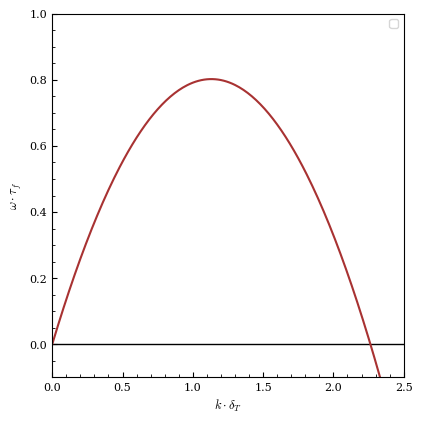

In [58]:
filepath = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Mathematica Notebooks")
data_csv_dir = filepath / "curves_theo.csv"
df =  pd.read_csv(data_csv_dir)
ax = plot_theo_growth_exp([df['new_plane'].to_list()], [df['k'].to_list()], [r'$\text{planar} \quad \;   \lambda =T^{0.7} $'],
                     colors=[colors_d[1]],plot_dims=(w_plot_fw*0.6, h_plot_fw))
#ax = plot_growth_exp([df_fz.iloc[::-1,1].to_numpy()], [df_fz.iloc[::-1,0].to_numpy()], labels=[r'$\text{F. et al.}$'], colors=['k'], ax1=ax)

ax.set_xlim(right=2.5)
ax.set_ylim(top=1.0)
ax.legend("")

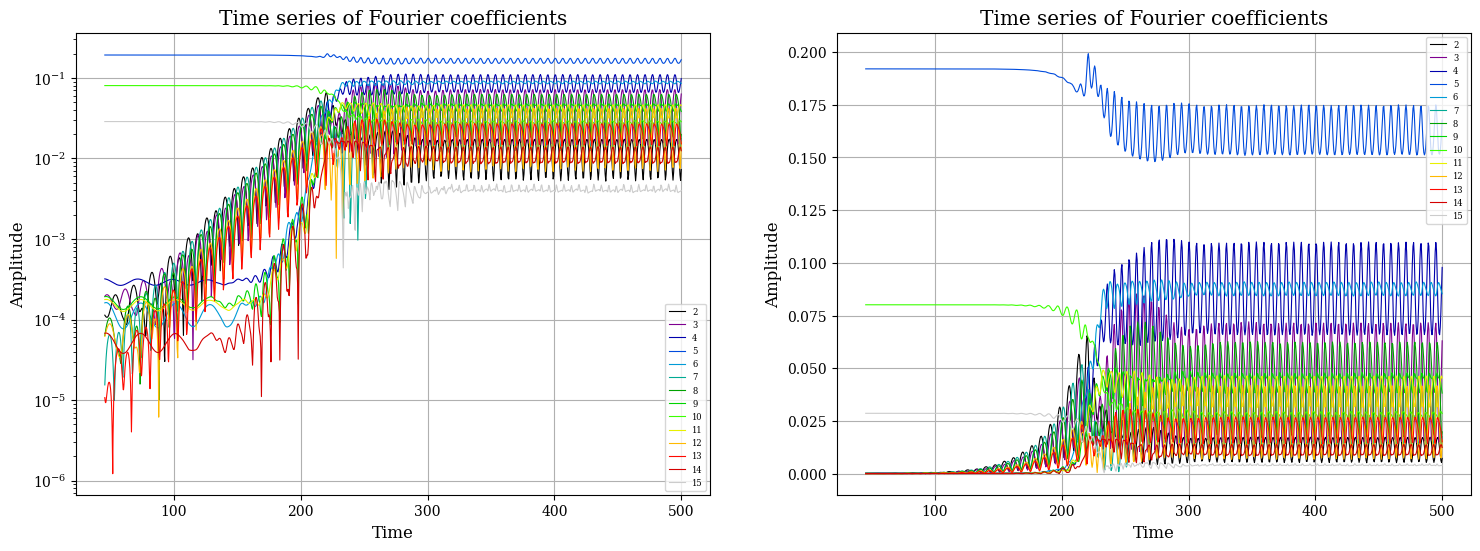

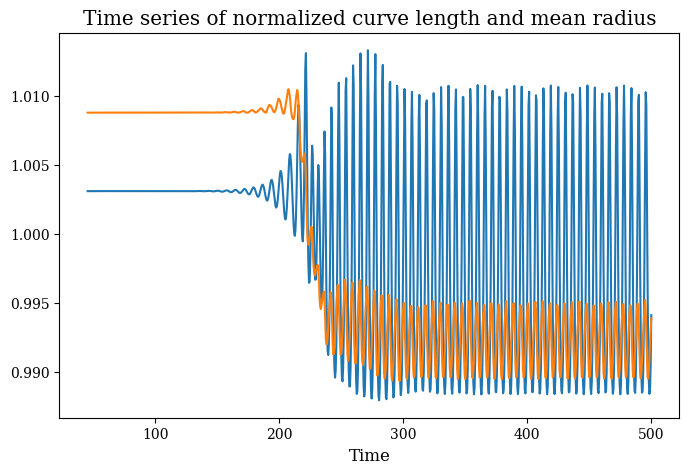

In [ ]:
"""Investigate the rotating case
"""
username = os.getlogin()
case1 = "base_18.4k_phi_0.6"
#case1 = "large_23.6k_phi_0.6"
#case1 = "base_18.4k_phi_0.75"
#case1 = "le1_18.4k_phi_0.75"
runs = ["01.75_03", "01.75_04", "01.75_05", "01.75_06", "01.75_07"]
dataset_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results")
case_dir = dataset_dir / case1
plt_s = slice(1, 15)

scalars_tot, amp_tot, k_r_tot, _, _ = extract_fourier_modes(runs, case_dir, method='fft')

my_cmap = plt.get_cmap('nipy_spectral')
colors = my_cmap(np.linspace(0, 1, (plt_s.stop - plt_s.start)))

# Plot whole time series of fourier coefficients
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
for i in range(plt_s.start, plt_s.stop):
    axes[0].semilogy(scalars_tot[:,0], amp_tot[:,i], color=colors[i-plt_s.start], label=str(i+1), linewidth=0.8)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Time series of Fourier coefficients')
axes[0].grid(True)
axes[0].legend(prop={'size': 6})

for i in range(plt_s.start, plt_s.stop):
    axes[1].plot(scalars_tot[:,0], amp_tot[:,i], color=colors[i-plt_s.start], label=str(i+1), linewidth=0.8)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('Time series of Fourier coefficients')
axes[1].grid(True)
axes[1].legend(prop={'size': 6})

plt.figure(figsize=(8, 5))
plt.plot(scalars_tot[:,0], scalars_tot[:,2]/np.mean(scalars_tot[:,2]))
plt.plot(scalars_tot[:,0], scalars_tot[:,3]/np.mean(scalars_tot[:,3]))
plt.title('Time series of normalized curve length and mean radius')
plt.xlabel('Time')
plt.show()

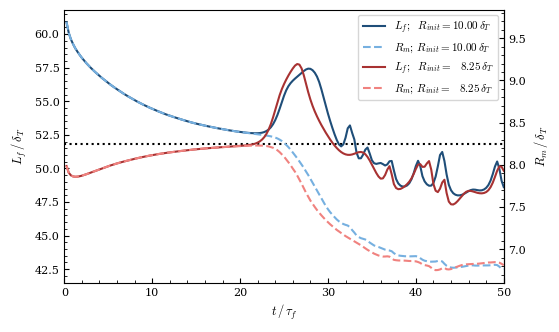

In [ ]:
"""Plot the comparison of total length and mean radius at the same mass flux
"""
run_list = ["02.75_01", "02.75_02"]
case_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/base_18.4k_phi_0.6")


fig, ax = plt.subplots(figsize=(w_plot_mw, h_plot_mw))
ax.axhline(y=8.25*2*np.pi, color="k", linestyle=':')

scalars_tot, amp_tot, k_tot, amp_ni_tot, k_ni_tot = extract_fourier_modes(
    ["02.75_01"], case_dir, num_modes=1, nu_res=1, method='ls')
ax.plot(scalars_tot[:, 0], scalars_tot[:, 2], label=r'$L_{f}; \ \  R_{init}=10.00\,\delta_T$', color=colors_d[0])
ax.plot(scalars_tot[:, 0], scalars_tot[:, 3] * 2 * np.pi, label=r'$R_m; \, R_{init}=10.00\,\delta_T$', color=colors_l[0] , linestyle='--')

scalars_tot, amp_tot, k_tot, amp_ni_tot, k_ni_tot = extract_fourier_modes(
    ["02.75_02"], case_dir, num_modes=1, nu_res=1, method='ls')
ax.plot(scalars_tot[:, 0], scalars_tot[:, 2], label=r'$L_{f}; \ \ R_{init}= \ \ \, 8.25\,\delta_T$', color=colors_d[1])
ax.plot(scalars_tot[:, 0], scalars_tot[:, 3] * 2 * np.pi, label=r'$R_m; \, R_{init}= \ \ \, 8.25\,\delta_T$', color=colors_l[1] , linestyle='--')

# Primary axis settings
ax.set_xlabel(r'$t \,/ \, \tau_f$')
ax.set_ylabel(r'$L_{f} \, / \, \delta_T$')
ax.tick_params(axis='both', which='both', labelcolor='black', direction='in')
ax.minorticks_on()
ax.margins(x=0)
ax.set_xlim(left=0)
ax.legend()
def forward(y): return y / (2 * np.pi)
def inverse(y): return y * (2 * np.pi)

ax2 = ax.secondary_yaxis('right', functions=(forward, inverse))
ax2.set_ylabel(r'$R_{m} \, / \, \delta_T$', color='black')
ax2.minorticks_on()
ax2.tick_params(axis='y', which='both', labelcolor='black', direction='in')
fig.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Comparisons/Length_time_comparison.png", 
            dpi=300, bbox_inches='tight')


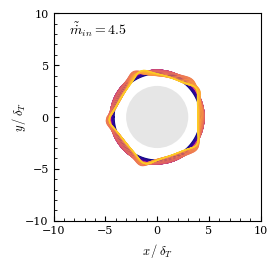

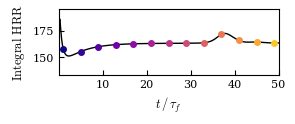

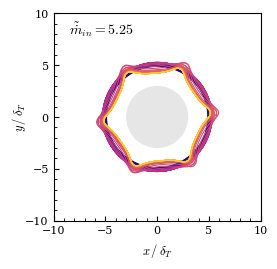

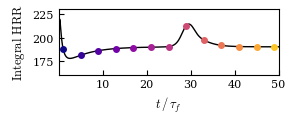

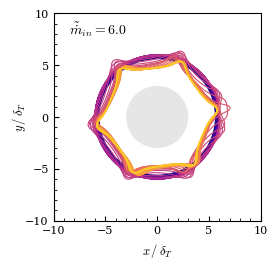

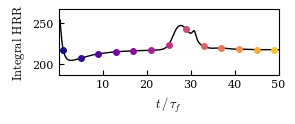

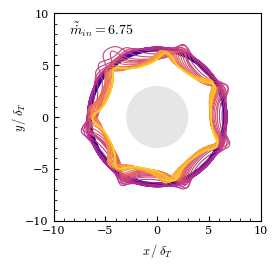

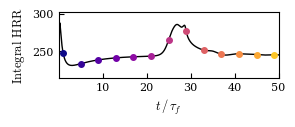

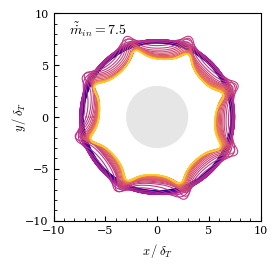

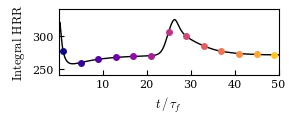

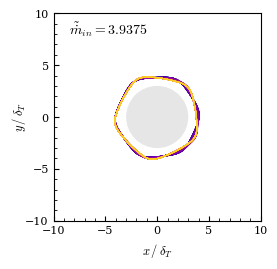

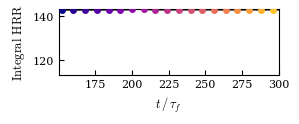

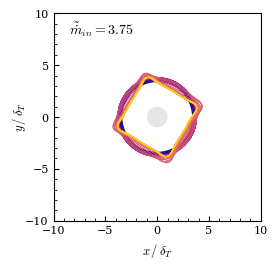

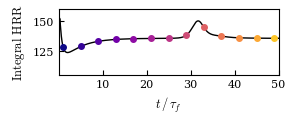

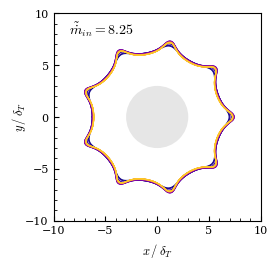

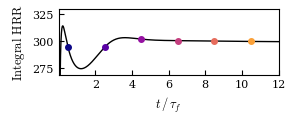

In [ ]:
"""Plot the comparison of total length and mean radius at the same mass flux
"""
run_list = ["01.50_01", "01.75_01", "02.00_01", "02.25_01", "02.50_01", "01.3125_03", "01.25_03", "02.75_08"]
time_starts = [ 0,  0,  0,  0,  0, 150,  0, 0]
time_stops  = [50, 50, 50, 50, 50, 300, 50, 12]
time_steps  = [ 1,  1,  1,  1,  1,   2,  1, 0.5]
case_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/base_18.4k_phi_0.6")

def plot_isotherm_prop(run_list, time_starts, time_stops, case_dir):
    for i, run in enumerate(run_list):
        fig, ax1 = plt.subplots(figsize=(w_plot_mw*0.5, w_plot_mw*0.5))
        timestep = time_steps[i]
        num_steps = int((time_stops[i] - time_starts[i]) / timestep)
        u_in, run_num = run.split("_")
        my_cmap = plt.get_cmap('plasma')

        colors = my_cmap(np.linspace(0, 0.9, num_steps))
        for j in range(0, num_steps):
            t = (j + 1) * timestep + time_starts[i]
            filepath = case_dir / f"Uin_{u_in}_RUN{run_num}" / "database" / f"Isotherm_T_3_t_{t:.2f}.okc"
            df = extract_fields_from_okc(filepath, ['x', 'y'])
            theta_unsorted, r_mean, r_fluc_unsorted = cartesian_df_to_polar(df)

            # Get the indices that would sort theta and sort the arrays
            sorted_indices = np.argsort(theta_unsorted)
            theta = theta_unsorted[sorted_indices]
            r_fluc = r_fluc_unsorted[sorted_indices]

            x = (r_fluc + r_mean) * np.cos(theta)
            y = (r_fluc + r_mean) * np.sin(theta)

            ax1.plot(x, y, label=r'$l_{tot}}$', color=colors[j], linewidth=0.8)

        if run == "01.25_03": r_in = 1 
        else: r_in = 3
        circle = patches.Circle((0, 0), r_in, facecolor='0.9', edgecolor='none')
        ax1.add_patch(circle)
        # Primary axis settings
        ax1.set_xlabel(r'$x \, / \, \delta_T$')
        ax1.set_ylabel(r'$y \, / \, \delta_T$', labelpad=-2)
        ax1.tick_params(axis='both', which='both', labelcolor='black', direction='in')
        ax1.minorticks_on()
        ax1.set_xticks([i for i in range(-10, 11, 5)])
        ax1.set_yticks([i for i in range(-10, 11, 5)])
        ax1.set_aspect('equal')
        ax1.margins()
        ax1.set_xlim(-10, 10)
        ax1.set_ylim(-10, 10)
        label = f"{r'$\tilde{\dot{m}}_{in}='}{float(u_in)*3}{r'$'}"
        ax1.text(-8.5, 8.0, label, fontsize=10, fontweight='bold')  # Top-left corner
        plt.tight_layout()
        plt.show()
        fig.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Isotherms_phi06/Isotherm_{run}.png"
                    , dpi=300, bbox_inches='tight')

        ihrr_dir = case_dir / f"Uin_{u_in}_RUN{run_num}/iHRR.csv"
        df = pd.read_csv(ihrr_dir)
        ihrr_timeseries = df.to_numpy()
        ihrr_stop_pad = 0
        ihrr_start_pad = 0
        y_lim = ihrr_timeseries[-1,1] - 30
        # start_ihrr = np.where(ihrr_timeseries[:,0] == (time_starts[i] - ihrr_start_pad))[0][0]
        stop_ihrr = np.where(ihrr_timeseries[:,0] == (time_stops[i] + ihrr_stop_pad))[0][0] 
        fig, ax = plt.subplots(figsize=(w_plot_mw*0.5, w_plot_mw * 0.15))
        ax.plot(ihrr_timeseries[:stop_ihrr+1,0], ihrr_timeseries[:stop_ihrr+1,1], label=r'$l_{tot}}$', color='black', linewidth=1.0)
        ax.set_xlabel(r'$t \, / \, \tau_f$')
        #ax.set_xlim(left=0)
        ax.set_ylabel(r'$\text{Integral HRR}$')
        ax.set_ylim(bottom=y_lim)
        ax.tick_params(axis='both', which='both', labelcolor='black', direction='in')
        #ax1.set_yticks([150, 200 ,250, 300, 350])
        
        for j in range(0, num_steps, 4):
            t = (j + 1) * timestep + time_starts[i]
            ihrr = ihrr_timeseries[ihrr_timeseries[:,0] == t, 1]
            ax.plot(t, ihrr, marker='o', color=colors[j], markersize=4, zorder=3)
            ax.margins(x=0)
        plt.show()
        fig.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Isotherms_phi06/iHRR_{run}.png", 
                    dpi=300, bbox_inches='tight')

plot_isotherm_prop(run_list, time_starts, time_stops, case_dir)

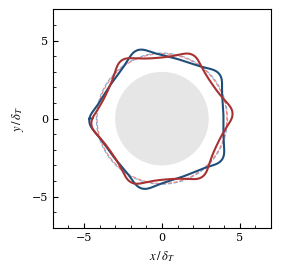

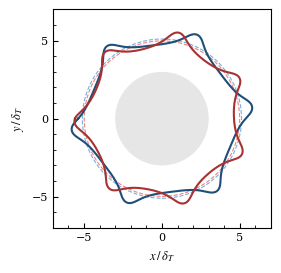

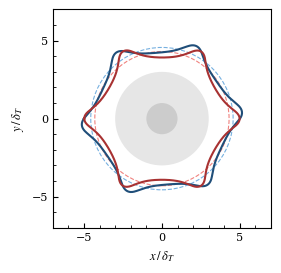

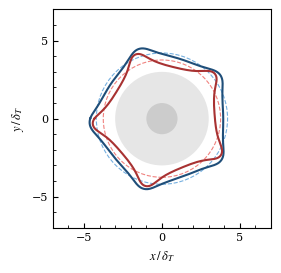

[[4.20507145 4.16128258]
 [5.10521418 4.9850726 ]
 [4.5652357  4.3052366 ]
 [4.20906441 3.76238557]]


In [ ]:
"""Plot the two final isotherms of same inlet vel but different fixed point and plot the final isotherm for a different inlet Radius
"""

plot_run_list = [["01.50_02", "01.50_03"], ["02.00_02", "02.00_06"], ["01.75_01", "01.75_08"], ["01.50_01", "01.50_04"]]
case_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/base_18.4k_phi_0.6")
t_final = [[100.00, 50.0], [100.0, 200.0], [50.0, 100.0], [50.0, 100.0]]

r_mean_comp = np.empty((len(plot_run_list), 2))
for i, run_list in enumerate(plot_run_list):
    fig, ax1 = plt.subplots(figsize=(w_plot_mw*0.5,w_plot_mw*0.5))
    
    for j, run in enumerate(run_list):
        t = t_final[i][j]
        #print(t)
        u_in, run_num = run.split("_")
        my_cmap = plt.get_cmap('plasma')

        colors = my_cmap(np.linspace(0, 0.9, 2))

        filepath = case_dir / f"Uin_{u_in}_RUN{run_num}" / "database" / f"Isotherm_T_3_t_{t:.2f}.okc"
        df = extract_fields_from_okc(filepath, ['x', 'y'])
        theta_unsorted, r_mean, r_fluc_unsorted = cartesian_df_to_polar(df)

        # Get the indices that would sort theta and sort the arrays
        sorted_indices = np.argsort(theta_unsorted)
        theta = theta_unsorted[sorted_indices]
        r_fluc = r_fluc_unsorted[sorted_indices]

        x = (r_fluc + r_mean) * np.cos(theta)
        y = (r_fluc + r_mean) * np.sin(theta)

        #label = f"{r'$\dot{m}_{in}='}{float(u_in)*3}{r'\, \rho_u$'}"
        #ax1.text(-6.0, 5.5, label)

        ax1.plot(x, y, label=r'$l_{tot}}$', color=['#1f4e79', '#a83232'][j], linewidth=1.5)
        circle = patches.Circle((0, 0), r_mean, facecolor='none', linewidth=0.8, edgecolor=['#76b0e0', '#f0827f'][j] , linestyle='--')
        ax1.add_patch(circle)
        r_mean_comp[i, j] = r_mean
    circle = patches.Circle((0, 0), 3, facecolor='0.9', edgecolor='none')
    ax1.add_patch(circle)
    if i > 1:
        circle = patches.Circle((0, 0), 1, facecolor='0.8', edgecolor='none')
        ax1.add_patch(circle)
    # Primary axis settings
    ax1.set_xlabel(r'$x \, / \, \delta_T$')
    ax1.set_ylabel(r'$y \, / \, \delta_T$', color='black')
    ax1.tick_params(axis='both', which='both', labelcolor='black', direction='in')
    ax1.minorticks_on()
    ax1.set_xticks([i for i in range(-10, 11, 5)])
    ax1.set_yticks([i for i in range(-10, 11, 5)])
    ax1.set_aspect('equal')
    ax1.margins()
    ax1.set_xlim(-7, 7)
    ax1.set_ylim(-7, 7)
    #plt.tight_layout()
    plt.show()
    fig.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Isotherms_phi06/Isotherm_comp_{run_list[0]}_{run_list[1]}.png", dpi=300,bbox_inches='tight')

print(r_mean_comp)

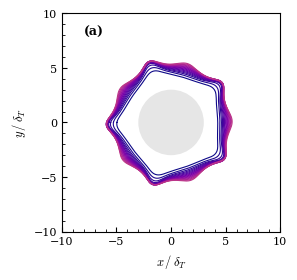

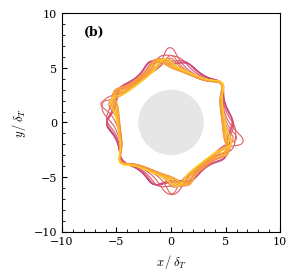

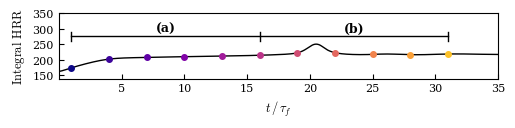

In [ ]:
"""Plot the transition of one into another
"""

run_list = ["02.00_04", "02.00_04"]
time_starts = [  0, 15]
time_stops  = [ 16, 31]
time_steps  = [  1,  1]
case_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/base_18.4k_phi_0.6")

my_cmap = plt.get_cmap('plasma')

colors = my_cmap(np.linspace(0, 0.9, int(time_stops[-1] / time_steps[-1] + 1)))
c = 0
u_in, run_num = run_list[0].split("_")
for i, run in enumerate(run_list):
    fig, ax1 = plt.subplots(figsize=(w_plot_mw*0.5,w_plot_mw*0.5))
    timestep = time_steps[i]
    num_steps = int((time_stops[i] - time_starts[i]) / timestep)


    for j in range(0, num_steps):
        t = (j + 1) * timestep + time_starts[i]
        filepath = case_dir / f"Uin_{u_in}_RUN{run_num}" / "database" / f"Isotherm_T_3_t_{t:.2f}.okc"
        df = extract_fields_from_okc(filepath, ['x', 'y'])
        theta_unsorted, r_mean, r_fluc_unsorted = cartesian_df_to_polar(df)

        # print(t)
        # Get the indices that would sort theta and sort the arrays
        sorted_indices = np.argsort(theta_unsorted)
        theta = theta_unsorted[sorted_indices]
        r_fluc = r_fluc_unsorted[sorted_indices]

        x = (r_fluc + r_mean) * np.cos(theta)
        y = (r_fluc + r_mean) * np.sin(theta)
    
        ax1.plot(x, y, label=r'$l_{tot}}$', color=colors[c], linewidth=0.8)
        c += 1

    circle = patches.Circle((0, 0), 3, facecolor='0.9', edgecolor='none')
    ax1.add_patch(circle)
    # Primary axis settings
    ax1.set_xlabel(r'$x \, / \, \delta_T$')
    ax1.set_ylabel(r'$y \, / \, \delta_T$', color='black')
    ax1.tick_params(axis='both', which='both', labelcolor='black', direction='in')
    ax1.minorticks_on()
    ax1.set_xticks([i for i in range(-10, 11, 5)])
    ax1.set_yticks([i for i in range(-10, 11, 5)])
    ax1.set_aspect('equal')
    ax1.margins()
    ax1.set_xlim(-10, 10)
    ax1.set_ylim(-10, 10)
    #plt.tight_layout()
    label = '(a)' if i == 0 else '(b)'
    ax1.text(-8, 8.0, label, fontweight='bold')  # Top-left corner
    plt.show()
    fig.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Isotherms_phi06/Isotherm_{run}_{i}.png", dpi=300,bbox_inches='tight')

ihrr_dir = case_dir / f"Uin_{u_in}_RUN{run_num}/iHRR.csv"
df = pd.read_csv(ihrr_dir)
ihrr_timeseries = df.to_numpy()
fig, ax1 = plt.subplots(figsize=(w_plot_mw, w_plot_mw*0.15))
stop_ihrr = int(len(ihrr_timeseries) * 0.70)
ax1.plot(ihrr_timeseries[:stop_ihrr,0], ihrr_timeseries[:stop_ihrr,1], label=r'$l_{tot}}$', color='black', linewidth=1.0)
ax1.set_xlabel(r'$t \, / \, \tau_f$')
ax1.set_ylabel(r'$\text{Integral HRR}$')
ax1.set_ylim(bottom=140)
ax1.tick_params(axis='both', which='both', labelcolor='black', direction='in')
ax1.set_yticks([150, 200 ,250, 300, 350])

arrow_y = 275  # Vertical position for the arrows (just below the curve)
label_y = 320  # Text label position
y_offset = 15
ax1.plot([1, 31],  [arrow_y, arrow_y], color='black', linewidth=1.0)
ax1.plot([1, 1],   [arrow_y-y_offset, arrow_y+y_offset], color='black', linewidth=1.0)
ax1.plot([16, 16], [arrow_y-y_offset, arrow_y+y_offset], color='black', linewidth=1.0)
ax1.plot([31, 31], [arrow_y-y_offset, arrow_y+y_offset], color='black', linewidth=1.0)
ax1.text(8.5, label_y, '(a)', ha='center', va='top', fontweight='bold')
ax1.text(23.5, label_y, '(b)', ha='center', va='top', fontweight='bold')

for j in range(0, int(time_stops[-1] / time_steps[-1]), 3):
    t = (j + 1) * timestep
    #print(t)
    ihrr = ihrr_timeseries[ihrr_timeseries[:,0] == t, 1]
    ax1.plot(t, ihrr, marker='o', color=colors[j], markersize=4, zorder=3)
    ax1.margins(x=0)
plt.show()
fig.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Isotherms_phi06/iHRR_{run}.png", dpi=300,bbox_inches='tight')

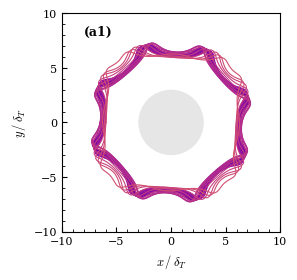

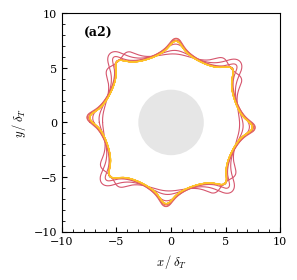

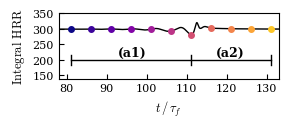

In [ ]:
"""Plot the rotation of one into another
"""
run_list = ["02.75_04", "02.75_05"]
time_break = 111.0
run_break = 100 - time_break % 1
time_step = 1
t_off = 50
case_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/base_18.4k_phi_0.6")

def plot_split_case(case_dir, run_list, t_off, time_break, run_break, time_step, plotlabels=None):
    time_starts = [time_break - 31 - t_off, run_break]
    time_stops  = [run_break - t_off, time_break + 20]
    time_steps  = [time_step, time_step]


    my_cmap = plt.get_cmap('plasma')

    colors = my_cmap(np.linspace(0, 0.9, int((time_stops[-1] - (time_starts[0] + t_off)) / time_steps[-1] + 1)))
    c = 0
    fig, ax1 = plt.subplots(figsize=(w_plot_mw*0.5,w_plot_mw*0.5))
    ihrr_timeseries = np.empty((0,2)) 
    t_list = []
    for i, run in enumerate(run_list):
        timestep = time_steps[i]
        num_steps = int((time_stops[i] - time_starts[i]) / timestep)
        u_in, run_num = run.split("_")
        ihrr_dir = case_dir / f"Uin_{u_in}_RUN{run_num}/iHRR.csv"
        df = pd.read_csv(ihrr_dir)
        ihrr_timeseries = np.append(ihrr_timeseries, df.to_numpy(), axis=0)
        for j in range(0, num_steps):
            t = (j + 1) * timestep + time_starts[i]
            t_list.append(t)
            #print(t)
            filepath = case_dir / f"Uin_{u_in}_RUN{run_num}" / "database" / f"Isotherm_T_3_t_{t:.2f}.okc"
            df = extract_fields_from_okc(filepath, ['x', 'y'])
            theta_unsorted, r_mean, r_fluc_unsorted = cartesian_df_to_polar(df)

            # print(t)
            # Get the indices that would sort theta and sort the arrays
            sorted_indices = np.argsort(theta_unsorted)
            theta = theta_unsorted[sorted_indices]
            r_fluc = r_fluc_unsorted[sorted_indices]

            x = (r_fluc + r_mean) * np.cos(theta)
            y = (r_fluc + r_mean) * np.sin(theta)
        
            ax1.plot(x, y, label=r'$l_{tot}}$', color=colors[c], linewidth=0.8)
            c += 1
            if t == time_stops[1] or t == time_break:
                circle = patches.Circle((0, 0), 3, facecolor='0.9', edgecolor='none')
                ax1.add_patch(circle)
                # Primary axis settings
                ax1.set_xlabel(r'$x \, / \, \delta_T$')
                ax1.set_ylabel(r'$y \, / \, \delta_T$', color='black')
                ax1.tick_params(axis='both', which='both', labelcolor='black', direction='in')
                ax1.minorticks_on()
                ax1.set_xticks([i for i in range(-10, 11, 5)])
                ax1.set_yticks([i for i in range(-10, 11, 5)])
                ax1.set_aspect('equal')
                ax1.margins()
                ax1.set_xlim(-10, 10)
                ax1.set_ylim(-10, 10)
                #plt.tight_layout()
                if plotlabels is None:
                    label = f'(a)' if t == time_break else f'(b)'
                else:
                    label = plotlabels[0] if t == time_break else plotlabels[1]
                ax1.text(-8, 8.0, label, fontweight='bold')  # Top-left corner
                plt.show()
                fig.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Isotherms_phi06/Isotherm_02.75_{t}.png", dpi=300,bbox_inches='tight')
                if t == time_break:
                    fig, ax1 = plt.subplots(figsize=(w_plot_mw*0.5,w_plot_mw*0.5))
                    ax1.plot(x, y, label=r'$l_{tot}}$', color=colors[c], linewidth=0.8)
    #print(t_list)
    ihrr_stop_pad = 2
    ihrr_start_pad = 2
    start_ihrr = np.where(ihrr_timeseries[:,0] == (time_starts[0] + t_off - ihrr_start_pad))[0][0]
    stop_ihrr = np.where(ihrr_timeseries[:,0] == (time_stops[-1] + ihrr_stop_pad))[0][0]
    fig, ax1 = plt.subplots(figsize=(w_plot_mw*0.5, w_plot_mw*0.15))

    ax1.plot(ihrr_timeseries[start_ihrr:stop_ihrr,0], ihrr_timeseries[start_ihrr:stop_ihrr,1], label=r'$l_{tot}}$', color='black', linewidth=1.0)
    ax1.set_xlabel(r'$t \, / \, \tau_f$')
    ax1.set_ylabel(r'$\text{Integral HRR}$')
    ax1.set_ylim(bottom=140)
    ax1.tick_params(axis='both', which='both', labelcolor='black', direction='in')
    ax1.set_yticks([150, 200 ,250, 300, 350])

    arrow_y = 200  # Vertical position for the arrows (just below the curve)
    label_y = 245  # Text label position
    y_offset = 15
    ax1.plot([time_starts[0] + t_off + 1, time_stops[-1]],  [arrow_y, arrow_y], color='black', linewidth=1.0)
    ax1.plot([time_starts[0] + t_off + 1, time_starts[0] + t_off + 1],   [arrow_y-y_offset, arrow_y+y_offset], color='black', linewidth=1.0)
    ax1.plot([time_break, time_break], [arrow_y-y_offset, arrow_y+y_offset], color='black', linewidth=1.0)
    ax1.plot([time_stops[-1], time_stops[-1]], [arrow_y-y_offset, arrow_y+y_offset], color='black', linewidth=1.0)
    ax1.text((time_break - time_starts[0] - t_off) / 2 + time_starts[0] + t_off + 1, label_y, plotlabels[0], ha='center', va='top', fontweight='bold')
    ax1.text((time_stops[-1] - time_break) / 2 + time_break, label_y, plotlabels[1], ha='center', va='top', fontweight='bold')

    for j in range(0, int((time_stops[-1] - time_starts[0] - t_off) / time_steps[-1]), 5):
        t = (j + 1) * timestep + time_starts[0] + t_off
        ihrr = ihrr_timeseries[ihrr_timeseries[:,0] == t, 1]
        ax1.plot(t, ihrr, marker='o', color=colors[j], markersize=4, zorder=3)
        ax1.margins(x=0)
    plt.show()
    fig.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Isotherms_phi06/iHRR_{run}.png", dpi=300,bbox_inches='tight')

plot_split_case(case_dir, run_list, t_off, time_break, run_break, time_step, plotlabels=["(a1)", "(a2)"])

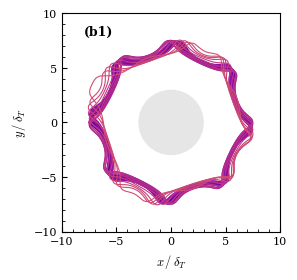

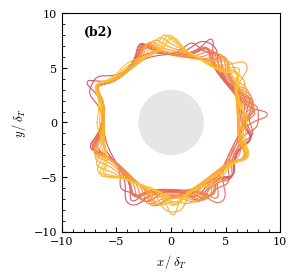

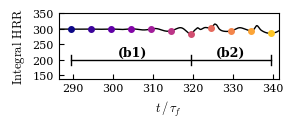

In [ ]:
"""Plot the rotation of one into another
"""
run_list = ["02.75_06", "02.75_07"]
time_break = 319.5
run_break =  300 - time_break % 1
time_step = 1
t_off = 0
case_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/base_18.4k_phi_0.6")

plot_split_case(case_dir, run_list, t_off, time_break, run_break, time_step, plotlabels=["(b1)", "(b2)"])

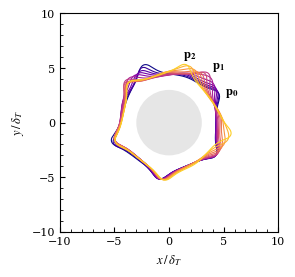

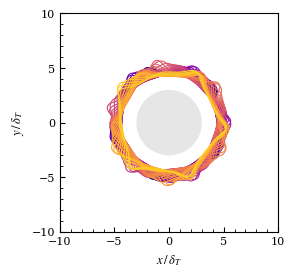

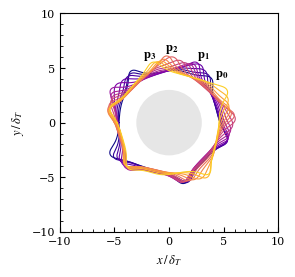

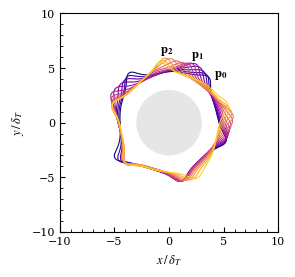

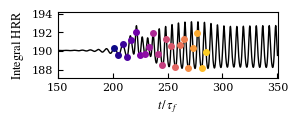

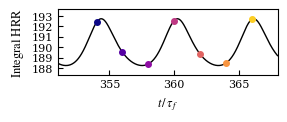

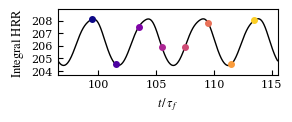

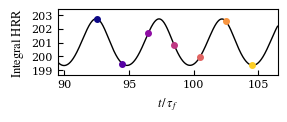

[13. 85. 15. 13.]


In [ ]:
"""Plot the limit cycle rotation
"""
my_cmap = plt.get_cmap('plasma')

run_list = ["01.75_07", "01.75_05", "01.90_01", "01.85_01"]
time_starts = [353, 200, 98.5, 91.5]
time_stops  = [366, 285, 113.5, 104.5]
time_steps  = [ 1,1,1,1]
case_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/base_18.4k_phi_0.6")


for i, run in enumerate(run_list):
    fig, ax1 = plt.subplots(figsize=(w_plot_mw*0.5,w_plot_mw*0.5))
    timestep = time_steps[i]
    num_steps = int((time_stops[i] - time_starts[i]) / timestep)
    u_in, run_num = run.split("_")
    colors = my_cmap(np.linspace(0, 0.9, num_steps))
    for j in range(0, num_steps):
        t = (j + 1) * timestep + time_starts[i]
        filepath = case_dir / f"Uin_{u_in}_RUN{run_num}" / "database" / f"Isotherm_T_3_t_{t:.2f}.okc"
        df = extract_fields_from_okc(filepath, ['x', 'y'])
        theta_unsorted, r_mean, r_fluc_unsorted = cartesian_df_to_polar(df)
        # Get the indices that would sort theta and sort the arrays
        sorted_indices = np.argsort(theta_unsorted)
        theta = theta_unsorted[sorted_indices]
        r_fluc = r_fluc_unsorted[sorted_indices]
        x = (r_fluc + r_mean) * np.cos(theta)
        y = (r_fluc + r_mean) * np.sin(theta)
        ax1.plot(x, y, label=r'$l_{tot}}$', color=colors[j], linewidth=0.8)
    circle = patches.Circle((0, 0), 3, facecolor='0.9', edgecolor='none')
    ax1.add_patch(circle)
    # Primary axis settings
    ax1.set_xlabel(r'$x \, / \, \delta_T$')
    ax1.set_ylabel(r'$y \, / \, \delta_T$', color='black')
    ax1.tick_params(axis='both', which='both', labelcolor='black', direction='in')
    ax1.minorticks_on()
    ax1.set_xticks([i for i in range(-10, 11, 5)])
    ax1.set_yticks([i for i in range(-10, 11, 5)])
    ax1.set_aspect('equal')
    ax1.margins()
    ax1.set_xlim(-10, 10)
    ax1.set_ylim(-10, 10)
    #plt.tight_layout()
    if i == 0:
        ax1.text(5.1, 2.6, r'$\mathbf{p_0}$')
        ax1.text(3.9, 5.0, r'$\mathbf{p_1}$')
        ax1.text(1.3, 6.0, r'$\mathbf{p_2}$')
    elif i == 2:
        ax1.text(4.2, 4.2, r'$\mathbf{p_0}$')   
        ax1.text(2.6, 6.0, r'$\mathbf{p_1}$')  
        ax1.text(-0.4, 6.6, r'$\mathbf{p_2}$') 
        ax1.text(-2.4, 6.0, r'$\mathbf{p_3}$')
    elif i == 3:
        ax1.text(4.1, 4.2, r'$\mathbf{p_0}$')
        ax1.text(2.0, 6.0, r'$\mathbf{p_1}$')
        ax1.text(-0.8, 6.4, r'$\mathbf{p_2}$') 
    plt.show()
    fig.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Isotherms_phi06/Isotherm_{run}_{i}.png", dpi=300, bbox_inches='tight')

ihrr_timeseries = np.empty((0,2)) 
fig, ax1 = plt.subplots(figsize=(w_plot_mw*0.5, w_plot_mw*0.15))

for run_num in ['04', '05', '06', '07']:
    u_in = '01.75'    
    ihrr_dir = case_dir / f"Uin_{u_in}_RUN{run_num}/iHRR.csv"
    df = pd.read_csv(ihrr_dir)
    ihrr_timeseries = np.append(ihrr_timeseries, df.to_numpy(), axis=0)

start_ihrr = np.where(ihrr_timeseries[:,0] == 150)[0][0]
stop_ihrr = np.where(ihrr_timeseries[:,0] == 350.1)[0][0]

ax1.plot(ihrr_timeseries[start_ihrr:stop_ihrr,0], ihrr_timeseries[start_ihrr:stop_ihrr,1], label=r'$l_{tot}}$', color='black', linewidth=1.0)
ax1.set_xlabel(r'$t \, / \, \tau_f$')
ax1.set_ylabel(r'$\text{Integral HRR}$')

num_steps = int((time_stops[1] - time_starts[1]) / time_steps[1])
for j in range(0, num_steps, 4):
    colors = my_cmap(np.linspace(0, 0.9, num_steps))
    t = (j + 1) * time_steps[1] + time_starts[1]
    ihrr = ihrr_timeseries[ihrr_timeseries[:,0] == t, 1]
    ax1.plot(t, ihrr, marker='o', color=colors[j], markersize=4, zorder=3)
ax1.margins(x=0)
ax1.margins(y=0.2)

ax1.tick_params(axis='both', which='both', labelcolor='black', direction='in')
ax1.yaxis.set_major_locator(plt.MultipleLocator(2))


plt.show()
fig.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Isotherms_phi06/iHRR_01.75_0.png", dpi=300,bbox_inches='tight')


fig, ax1 = plt.subplots(figsize=(w_plot_mw*0.5, w_plot_mw*0.15))

ihrr_stop_pad = 2
ihrr_start_pad = 2
start_ihrr = np.where(ihrr_timeseries[:,0] == (time_starts[0] - ihrr_start_pad))[0][0]
stop_ihrr = np.where(ihrr_timeseries[:,0] == (time_stops[0] + ihrr_stop_pad))[0][0]
ax1.plot(ihrr_timeseries[start_ihrr:stop_ihrr,0], ihrr_timeseries[start_ihrr:stop_ihrr,1], label=r'$l_{tot}}$', color='black', linewidth=1.0)
ax1.set_xlabel(r'$t \, / \, \tau_f$')
ax1.set_ylabel(r'$\text{Integral HRR}$')

num_steps = int((time_stops[0] - time_starts[0]) / time_steps[0])
for j in range(0, num_steps, 2):
    colors = my_cmap(np.linspace(0, 0.9, num_steps))
    t = (j + 1) * time_steps[0] + time_starts[0]
    ihrr = ihrr_timeseries[ihrr_timeseries[:,0] == t, 1]
    ax1.plot(t, ihrr, marker='o', color=colors[j], markersize=4, zorder=3)
       
ax1.margins(x=0)
ax1.margins(y=0.2)

ax1.set_ylim(bottom=None)
ax1.tick_params(axis='both', which='both', labelcolor='black', direction='in')
ax1.yaxis.set_major_locator(plt.MultipleLocator(1))
plt.show()
fig.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Isotherms_phi06/iHRR_01.75_1.png", dpi=300,bbox_inches='tight')

fig, ax1 = plt.subplots(figsize=(w_plot_mw*0.5, w_plot_mw*0.15))

ihrr_dir = case_dir / f"Uin_01.90_RUN01/iHRR.csv"
df = pd.read_csv(ihrr_dir)
ihrr_timeseries = df.to_numpy()
ihrr_stop_pad = 2
ihrr_start_pad = 2
start_ihrr = np.where(ihrr_timeseries[:,0] == (time_starts[2] - ihrr_start_pad))[0][0]
stop_ihrr = np.where(ihrr_timeseries[:,0] == (time_stops[2] + ihrr_stop_pad))[0][0]
ax1.plot(ihrr_timeseries[start_ihrr:stop_ihrr,0], ihrr_timeseries[start_ihrr:stop_ihrr,1], label=r'$l_{tot}}$', color='black', linewidth=1.0)
ax1.set_xlabel(r'$t \, / \, \tau_f$')
ax1.set_ylabel(r'$\text{Integral HRR}$')

num_steps = int((time_stops[2] - time_starts[2]) / time_steps[2])
for j in range(0, num_steps, 2):
    colors = my_cmap(np.linspace(0, 0.9, num_steps))
    t = (j + 1) * time_steps[2] + time_starts[2]
    ihrr = ihrr_timeseries[ihrr_timeseries[:,0] == t, 1]
    ax1.plot(t, ihrr, marker='o', color=colors[j], markersize=4, zorder=3)
       
ax1.margins(x=0)
ax1.margins(y=0.2)

ax1.set_ylim(bottom=None)
ax1.tick_params(axis='both', which='both', labelcolor='black', direction='in')
ax1.xaxis.set_major_locator(plt.MultipleLocator(5))
ax1.yaxis.set_major_locator(plt.MultipleLocator(1))
plt.show()
fig.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Isotherms_phi06/iHRR_01.90_1.png", dpi=300,bbox_inches='tight')

fig, ax1 = plt.subplots(figsize=(w_plot_mw*0.5, w_plot_mw*0.15))

ihrr_dir = case_dir / f"Uin_01.85_RUN01/iHRR.csv"
df = pd.read_csv(ihrr_dir)
ihrr_timeseries = df.to_numpy()
ihrr_stop_pad = 2
ihrr_start_pad = 2
start_ihrr = np.where(ihrr_timeseries[:,0] == (time_starts[3] - ihrr_start_pad))[0][0]
stop_ihrr = np.where(ihrr_timeseries[:,0] == (time_stops[3] + ihrr_stop_pad))[0][0]
ax1.plot(ihrr_timeseries[start_ihrr:stop_ihrr,0], ihrr_timeseries[start_ihrr:stop_ihrr,1], label=r'$l_{tot}}$', color='black', linewidth=1.0)
ax1.set_xlabel(r'$t \, / \, \tau_f$')
ax1.set_ylabel(r'$\text{Integral HRR}$')

num_steps = int((time_stops[3] - time_starts[3]) / time_steps[3])
for j in range(0, num_steps, 2):
    colors = my_cmap(np.linspace(0, 0.9, num_steps))
    t = (j + 1) * time_steps[3] + time_starts[3]
    ihrr = ihrr_timeseries[ihrr_timeseries[:,0] == t, 1]
    ax1.plot(t, ihrr, marker='o', color=colors[j], markersize=4, zorder=3)
       
ax1.margins(x=0)
ax1.margins(y=0.2)

ax1.set_ylim(bottom=None)
ax1.tick_params(axis='both', which='both', labelcolor='black', direction='in')
ax1.xaxis.set_major_locator(plt.MultipleLocator(5))
ax1.yaxis.set_major_locator(plt.MultipleLocator(1))
#ax1.set_yticks([185, 195])
plt.show()
fig.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Isotherms_phi06/iHRR_01.85_1.png", dpi=300,bbox_inches='tight')

print(np.array(time_stops) - np.array(time_starts))

In [71]:
"""Plot the rotation of one into another
"""
from scipy.signal import savgol_filter
from matplotlib.collections import LineCollection

run_list = ["02.75_07"]
#time_starts = [352, 200]
#time_stops  = [368, 285]
time_starts = [360]
time_stops  = [500]
time_steps  = [0.5]
case_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/base_18.4k_phi_0.6")

def curvature_polar(theta, r):
    """
    Compute curvature for a polar curve r(theta).
    theta: array of angles (radians), sorted
    r: array of radii
    returns: curvature array
    """
    dr_dtheta = np.gradient(r, theta)
    d2r_dtheta2 = np.gradient(dr_dtheta, theta)
    numerator = r**2 + 2 * dr_dtheta**2 - r * d2r_dtheta2
    denominator = (r**2 + dr_dtheta**2)**1.5

    return numerator / denominator

def curvature_polar_cart(theta, r):
    x = r * np.cos(theta)
    y = r * np.sin(theta)

    dx = np.gradient(x, theta)
    dy = np.gradient(y, theta)
    d2x = np.gradient(dx, theta)
    d2y = np.gradient(dy, theta)

    num = dx * d2y - dy * d2x
    den = (dx**2 + dy**2)**1.5

    return - num / den

def calculate_x_off(case_dir, run_list, time_starts, time_stops, time_steps, r_in):
    x_off = 0.0
    for i, run in enumerate(run_list):
            u_in, run_num = run.split("_")
            num_steps = int((time_stops[i] - time_starts[i]) / time_steps[i])
            for j in range(0, num_steps):
                t = (j + 1) * time_steps[i] + time_starts[i]
                filepath = case_dir / f"Uin_{u_in}_RUN{run_num}" / "database" / f"Isotherm_T_3_t_{t:.2f}.okc"
                df = extract_fields_from_okc(filepath, ['x', 'y'])
                _, r_mean, _ = cartesian_df_to_polar(df)
                x_off += time_steps[i] * r_in * float(u_in) / r_mean
    return x_off

def plot_pseudo_planar(case_dir, run_list, time_starts, time_stops, time_steps, r_in, plot_dims=(w_plot_fw, h_plot_fw), plot_cb='horizontal', overlap=False, rotation=0.0, x_offs=None):
    for i, run_plot in enumerate(run_list):
        t_list = []
        x_mean_list = []
        my_cmap = plt.get_cmap('plasma_r')

        if plot_dims[1]>plot_dims[0]:
            fig, ax1 = plt.subplots(figsize=(plot_dims[1], plot_dims[0]))
            swap_axis = True
        else:
            fig, ax1 = plt.subplots(figsize=plot_dims)
            swap_axis = False

        if isinstance(run_plot, str):
            run_plot = [run_plot]
            time_start = [time_starts[i]]
            time_stop = [time_stops[i]]
        else:
            time_start = time_starts[i]
            time_stop = time_stops[i]
            
        x_mean = 0 if x_offs is None else x_offs[i]
        for k, run in enumerate(run_plot):
            u_in, run_num = run.split("_")
            
            num_steps = int((time_stop[k] - time_start[k]) / time_steps[i])

            for j in range(0, num_steps):
                t = (j + 1) * time_steps[i] + time_start[k]
                filepath = case_dir / f"Uin_{u_in}_RUN{run_num}" / "database" / f"Isotherm_T_3_t_{t:.2f}.okc"
                df = extract_fields_from_okc(filepath, ['x', 'y'])
                theta_unsorted, r_mean, r_fluc_unsorted = cartesian_df_to_polar(df)
                #if j == 0 and k == 0: x_mean += r_mean 
                
                if overlap:
                    x_mean += time_steps[i] * r_in * float(u_in) / r_mean
                    y = theta_unsorted + rotation
                    x = x_mean - (r_fluc_unsorted + r_mean)  

                    if swap_axis:
                        ax1.scatter(y ,x, marker='.', s=0.5, color=colors_d[0], linewidths=0)
                    else:
                        ax1.scatter(x ,y, marker='.', s=0.5, color=colors_d[0], linewidths=0)
                
                else:
                    # Get the indices that would sort theta and sort the arrays
                    if rotation != 0.0:
                        theta_unsorted = np.mod(theta_unsorted + rotation + np.pi, 2*np.pi) - np.pi 
                    sorted_indices = np.argsort(theta_unsorted)
                    theta = theta_unsorted[sorted_indices]
                    r_fluc = r_fluc_unsorted[sorted_indices]

                    x_mean += time_steps[i] * r_in * float(u_in) / r_mean
                    y = theta
                    #x = x_mean - (r_fluc + r_mean)
                    x = x_mean - r_fluc

                    if swap_axis:
                        y = x
                        x = theta

                    points = np.array([x, y]).T.reshape(-1, 1, 2)
                    segments = np.concatenate([points[:-1], points[1:]], axis=1)

                        # Create colored line
                    norm = plt.Normalize(vmin=-2, vmax=1)
                    lc = LineCollection(segments, cmap=my_cmap, norm=norm)

                    ax1.add_collection(lc)
                    # r_smooth = savgol_filter(r_fluc + r_mean, window_length=5, polyorder=2, mode='wrap')
                    # Choose a window length (odd number) and polynomial order
                    kappa = curvature_polar_cart(theta, r_fluc + r_mean)
                    #kappa = -1*np.ones(len(theta))
                    lc.set_array(kappa)
                    lc.set_linewidth(0.4)
                    
                x_mean_list.append(x_mean)
                t_list.append(t)
        # Primary axis settings
        if plot_cb is not None: plt.colorbar(lc, ax=ax1, label=r'$\kappa$', orientation=plot_cb, fraction=0.046)
        
        x_ticks, t_ticks = [], []
        for t in range(time_start[0], time_stop[-1] + 1, 20):
            idx = np.abs(np.array(t_list) - t).argmin()
            x_ticks.append(x_mean_list[idx])
            t_ticks.append(t)
        ax1.autoscale()
        ax1.tick_params(axis='both', which='both', labelcolor='black', direction='in')
        ax1.tick_params(axis='both', which='both', labelcolor='black', direction='in')
        #ax1.minorticks_on()

        if swap_axis:
            ax1.set_aspect(1/r_mean)
            ax1.set_xlabel(r'$\varphi$')
            ax1.set_xticks([-np.pi + 0.5 * np.pi * i for i in range(5)])
            ax1.set_yticks(x_ticks, t_ticks)
            ax1.set_ylabel(r'$\tilde{x} \, / \, \delta_T$')
            ax1.set_xlim((-np.pi, np.pi))
            ax1.set_xticklabels([r'$-\pi$', r'$-\pi / 2$', r'$0$', r'$\pi / 2$', r'$\pi$'])
            ax1.margins(x=0.0001)
        else:
            ax1.set_aspect(r_mean)
            ax1.set_xticks(x_ticks, t_ticks)
            ax1.set_xlabel(r'$t \, / \, \tau_f$')
            ax1.set_ylabel(r'$\varphi$', labelpad=-2)
            ax1.set_yticks([-np.pi + 0.5 * np.pi * i for i in range(5)])
            ax1.set_ylim((-np.pi, np.pi))
            ax1.set_yticklabels([r'$-\pi$', r'$-\pi / 2$', r'$0$', r'$\pi / 2$', r'$\pi$'])
            ax1.margins(y=0.0001)

        

        plot_name = f"Isotherm_flattend_{run_plot[0]}_{time_start[0]}.png"
        fig.tight_layout()
        fig.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Isotherms_phi06/{plot_name}", 
                    dpi=300, bbox_inches='tight', pad_inches=0.01)
    #plt.tight_layout()

#plot_pseudo_planar(case_dir, run_list, time_starts, time_stops, time_steps, 3, x_offs=[448])

100.35611483484887
361.9292996855258
447.9359618239272


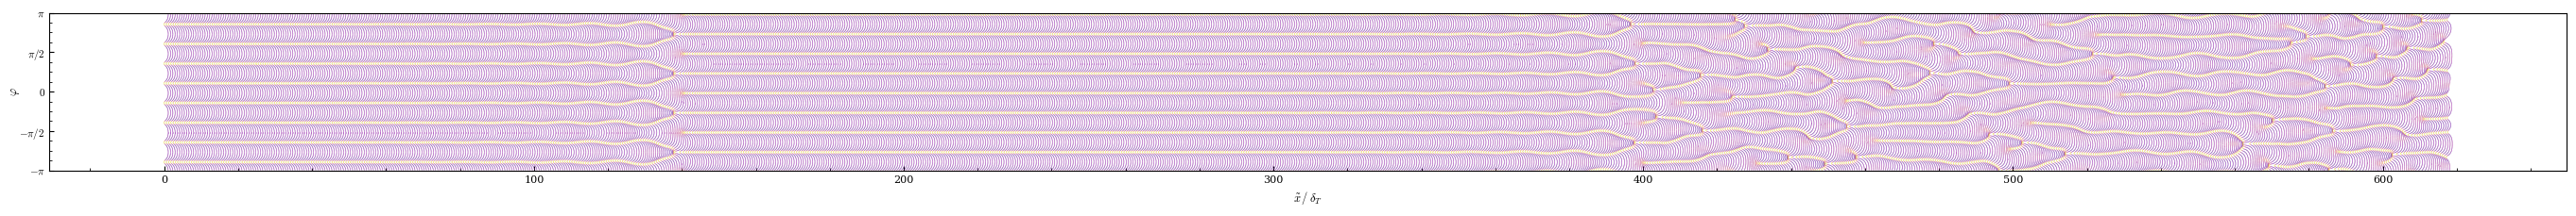

In [ ]:
# Calculate the x_offsets
run_list = ["02.75_03","02.75_04"]
time_starts = [0, 0]
time_stops  = [50, 30]
time_steps  = [0.5, 0.5]
print(calculate_x_off(case_dir, run_list, time_starts, time_stops, time_steps, 3))

run_list = ["02.75_03","02.75_04", "02.75_05", "02.75_06"]
time_starts = [0, 0, 100, 200]
time_stops  = [50, 50, 200, 290]
time_steps  = [0.5, 0.5, 0.5, 0.5]
print(calculate_x_off(case_dir, run_list, time_starts, time_stops, time_steps, 3))

run_list = ["02.75_03","02.75_04", "02.75_05", "02.75_06", "02.75_07"]
time_starts = [0, 0, 100, 200, 300]
time_stops  = [50, 50, 200, 300, 360]
time_steps  = [0.5, 0.5, 0.5, 0.5, 0.5]
plot_pseudo_planar(case_dir, [run_list], [time_starts], [time_stops[:-1] + [500]], time_steps, 3, plot_dims=(10*w_plot_s, h_plot_s), plot_cb=None)
print(calculate_x_off(case_dir, run_list, time_starts, time_stops, time_steps, 3))

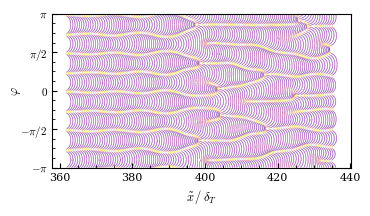

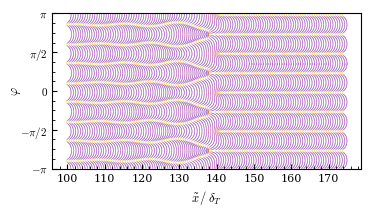

In [ ]:
run_list = [["02.75_06", "02.75_07"], ["02.75_04", "02.75_05"]]
time_starts = [[290, 300], [30, 100]]
time_stops  = [[300, 350], [50, 140]]
time_steps  = [0.5, 0.5]
plot_pseudo_planar(case_dir, run_list, time_starts, time_stops, time_steps, 3, plot_dims=(w_plot_s, h_plot_s), plot_cb=None, x_offs=[362, 100])


[4.725 4.536]
[4.725 3.024]


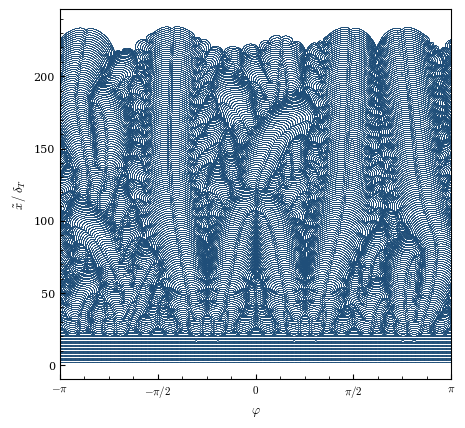

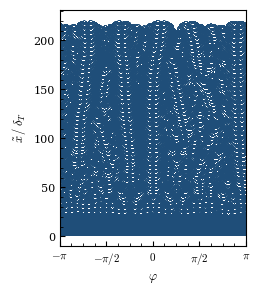

In [ ]:
case_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/vlarge_42k_phi_0.6")
run_list = [["03.00_01"]]
time_starts = [[0]]
time_stops  = [[170]]
time_steps  = [1.0]
plot_pseudo_planar(case_dir, run_list, time_starts, time_stops, time_steps, 20, plot_dims=(w_plot_fw*0.6, h_plot_fw,), plot_cb=None, overlap=True)
run_list = [["02.00_01"]]
time_starts = [[0]]
time_stops  = [[170]]
time_steps  = [1.0]
plot_pseudo_planar(case_dir, run_list, time_starts, time_stops, time_steps, 20, plot_dims=(w_plot_fw*0.4, h_plot_fw), plot_cb=None, overlap=True)

[7.56  4.725]
[7.56  4.725]


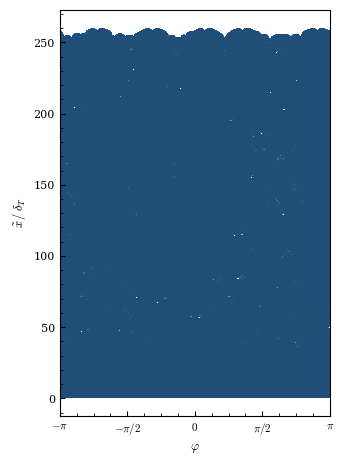

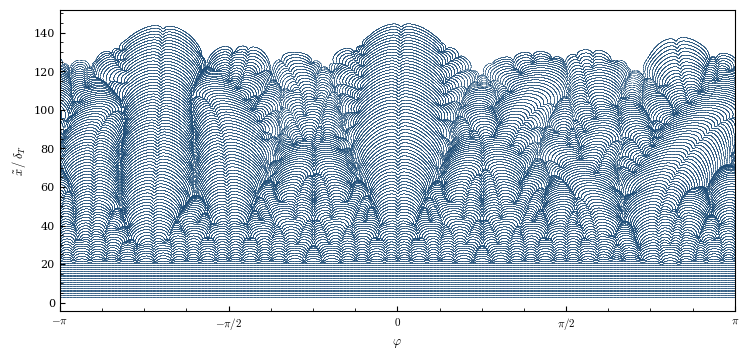

In [ ]:
case_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/vlarge_42k_phi_0.6")
run_list = [["02.00_01"], ["04.00_01"]]
time_starts = [[0], [0]]
time_stops  = [[200], [100]]
time_steps  = [0.5, 1.0]
plot_pseudo_planar(case_dir, run_list, time_starts, time_stops, time_steps, 20, plot_dims=(h_plot_fw, w_plot_fw), plot_cb=None, overlap=True)

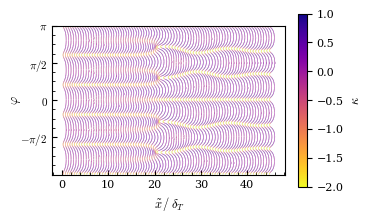

In [ ]:
case_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/base_18.4k_phi_0.6")
#run_list = [["02.00_04", "02.00_04"]]
#time_starts = [[0, 15]]
#time_stops  = [[16, 31]]
#time_steps = [0.5]
run_list = [["02.00_04"]]
time_starts = [[0]]
time_stops  = [[40]]
time_steps = [0.5]
plot_pseudo_planar(case_dir, run_list, time_starts, time_stops, time_steps, 3, plot_dims=(w_plot_s, h_plot_s), plot_cb='vertical', rotation=2.5)

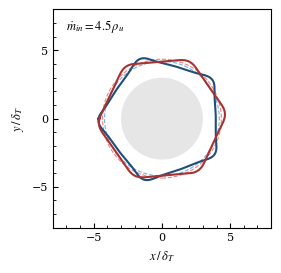

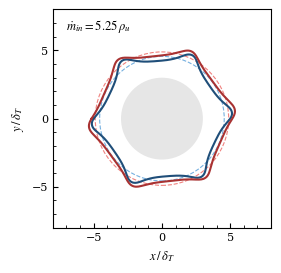

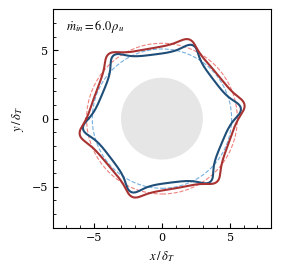

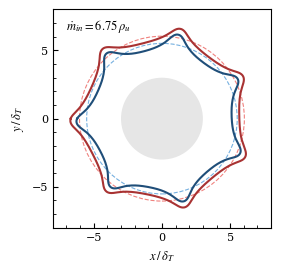

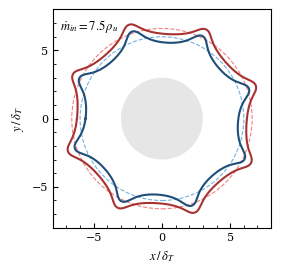

[[4.20507145 4.35483519]
 [4.5652357  4.89094689]
 [5.10521418 5.5247131 ]
 [5.51753359 6.0421941 ]
 [6.00089963 6.61026473]]
[0.03561503 0.07134597 0.08217068 0.09508968 0.10154562]


In [ ]:
"""Comparison of euqivalence ratio
"""

plot_run_list = [["01.50_02", "01.50_02"], ["01.75_01", "01.75_02"], ["02.00_02", "02.00_02"], ["02.25_02", "02.25_02"], ["02.50_02", "02.50_02"]]
case_dir_1 = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/base_18.4k_phi_0.6")
case_dir_2 = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/base_18.4k_phi_0.75")
t_final = [[100.00, 150.0], [50.0, 150.0], [100.0, 150.0], [100.0, 150.0], [100.0, 150.0]]

tau_f_1 = 0.03676 
tau_f_2 = 0.03509

r_mean_comp = np.empty((len(plot_run_list), 2))

for i, run_list in enumerate(plot_run_list):
    fig, ax1 = plt.subplots(figsize=(w_plot_mw*0.5, w_plot_mw*0.5))
    
    for j, run in enumerate(run_list):
        t = t_final[i][j]
        #print(t)
        u_in, run_num = run.split("_")
        my_cmap = plt.get_cmap('plasma')

        colors = my_cmap(np.linspace(0, 0.9, 2))

        if j == 0:  filepath = case_dir_1 / f"Uin_{u_in}_RUN{run_num}" / "database" / f"Isotherm_T_3_t_{t:.2f}.okc"
        else:       filepath = case_dir_2 / f"Uin_{u_in}_RUN{run_num}" / "database" / f"Isotherm_T_3_t_{t:.2f}.okc"
        df = extract_fields_from_okc(filepath, ['x', 'y'])
        theta_unsorted, r_mean, r_fluc_unsorted = cartesian_df_to_polar(df)

        # Get the indices that would sort theta and sort the arrays
        sorted_indices = np.argsort(theta_unsorted)
        theta = theta_unsorted[sorted_indices]
        r_fluc = r_fluc_unsorted[sorted_indices]

        if j == 0:  
            a = 1.0
            label = f"{r'$\dot{m}_{in}^*='}{float(u_in)*3}{r'$'}"
            if i == 4:  ax1.text(-7.5, 6.5, label, fontweight='bold')
            else:       ax1.text(-7.0, 6.5, label, fontweight='bold')
            

        else:   
            a = 1.0    
            #a = tau_f_2 / tau_f_1

        x = (r_fluc + r_mean) * np.cos(theta) * a
        y = (r_fluc + r_mean) * np.sin(theta) * a
    
        ax1.plot(x, y, label=r'$l_{tot}}$', color=['#1f4e79', '#a83232', '#d4a017'][j], linewidth=1.5)
        circle = patches.Circle((0, 0), r_mean * a, facecolor='none', linewidth=0.8, edgecolor=['#76b0e0', '#f0827f', '#f2d98c'][j] , linestyle='--')
        ax1.add_patch(circle)
        r_mean_comp[i, j] = r_mean * a
        
    circle = patches.Circle((0, 0), 3, facecolor='0.9', edgecolor='none')
    ax1.add_patch(circle)

    # Primary axis settings
    ax1.set_xlabel(r'$x \, / \, \delta_T$')
    ax1.set_ylabel(r'$y \, / \, \delta_T$', color='black')
    ax1.tick_params(axis='both', which='both', labelcolor='black', direction='in')
    ax1.minorticks_on()
    ax1.set_xticks([i for i in range(-10, 11, 5)])
    ax1.set_yticks([i for i in range(-10, 11, 5)])
    ax1.set_aspect('equal')
    ax1.margins()
    ax1.set_xlim(-8, 8)
    ax1.set_ylim(-8, 8)
    #plt.tight_layout()
    plt.show()
    fig.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Isotherms_phi06/Isotherm_comp_phi_06075_{run_list[0]}.png", dpi=300,bbox_inches='tight')

print(r_mean_comp)
print((r_mean_comp[:,1] - r_mean_comp[:,0]) / r_mean_comp[:,0])

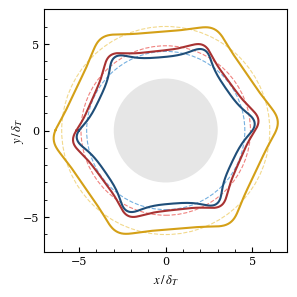

[[4.5652357  4.89094689 6.00492245]]


In [ ]:
"""Comparison of stable configuration for three equvalence ratios
"""

plot_run_list = [["01.75_01", "01.75_02", "01.75_02"]]
case_dir_1 = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/base_18.4k_phi_0.6")
case_dir_2 = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/base_18.4k_phi_0.75")
case_dir_3 = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/le1_18.4k_phi_0.75")
t_final = [[50.0, 150.0, 150.0]]

tau_f_1 = 0.03676 
tau_f_2 = 0.03509

r_mean_comp = np.empty((len(plot_run_list), 3))

for i, run_list in enumerate(plot_run_list):
    fig, ax1 = plt.subplots(figsize=(w_plot_s, w_plot_s))
    
    for j, run in enumerate(run_list):
        t = t_final[i][j]
        #print(t)
        u_in, run_num = run.split("_")
        my_cmap = plt.get_cmap('plasma')

        colors = my_cmap(np.linspace(0, 0.9, 2))

        if j == 0:          filepath = case_dir_1 / f"Uin_{u_in}_RUN{run_num}" / "database" / f"Isotherm_T_3_t_{t:.2f}.okc"
        elif j == 1:        filepath = case_dir_2 / f"Uin_{u_in}_RUN{run_num}" / "database" / f"Isotherm_T_3_t_{t:.2f}.okc"
        else:               filepath = case_dir_3 / f"Uin_{u_in}_RUN{run_num}" / "database" / f"Isotherm_T_3_t_{t:.2f}.okc"
        df = extract_fields_from_okc(filepath, ['x', 'y'])
        theta_unsorted, r_mean, r_fluc_unsorted = cartesian_df_to_polar(df)

        # Get the indices that would sort theta and sort the arrays
        sorted_indices = np.argsort(theta_unsorted)
        theta = theta_unsorted[sorted_indices]
        r_fluc = r_fluc_unsorted[sorted_indices]

        if j == 0:  
            a = 1.0
            label = f"{r'$\dot{m}_{in}^*='}{float(u_in)*3}{r'$'}"
            #ax1.text(-6.5, 6.0, label, fontsize=12, fontweight='bold')  # Top-left corner

        else:       
            a = 1.0
            # a = tau_f_2 / tau_f_1

        x = (r_fluc + r_mean) * np.cos(theta) * a
        y = (r_fluc + r_mean) * np.sin(theta) * a
    
        ax1.plot(x, y, label=r'$l_{tot}}$', color=['#1f4e79', '#a83232', '#d4a017'][j], linewidth=1.5)
        circle = patches.Circle((0, 0), r_mean * a, facecolor='none', linewidth=0.8, edgecolor=['#76b0e0', '#f0827f', '#f2d98c'][j] , linestyle='--')
        ax1.add_patch(circle)
        r_mean_comp[i, j] = r_mean * a
        
    circle = patches.Circle((0, 0), 3, facecolor='0.9', edgecolor='none')
    ax1.add_patch(circle)

    # Primary axis settings
    ax1.set_xlabel(r'$x \, / \, \delta_T$')
    ax1.set_ylabel(r'$y \, / \, \delta_T$', labelpad=-2)
    ax1.tick_params(axis='both', which='both', labelcolor='black', direction='in')
    ax1.minorticks_on()
    ax1.set_xticks([i for i in range(-10, 11, 5)])
    ax1.set_yticks([i for i in range(-10, 11, 5)])
    ax1.set_aspect('equal')
    ax1.margins()
    ax1.set_xlim(-7, 7)
    ax1.set_ylim(-7, 7)
    #plt.tight_layout()
    plt.show()
    fig.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Report/Figures/Isotherms_phi06/Isotherm_comp_phi_06075le1_{run_list[0]}.png", dpi=300,bbox_inches='tight')
    print(r_mean_comp)


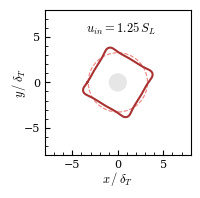

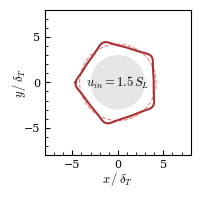

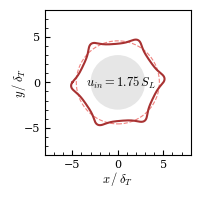

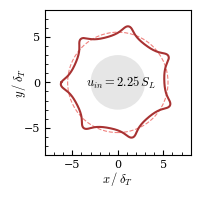

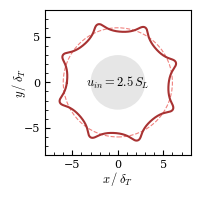

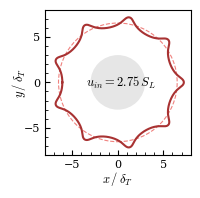

In [12]:
"""Combined plot for paper"""


plot_run_list = [["01.25_04"], ["01.50_02"], ["01.75_01"], ["02.25_02"], ["02.50_02"], ["02.75_08"]]
case_dir_1 = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/base_18.4k_phi_0.6")
#case_dir_2 = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/small_19.7k_phi_0.75")
t_final = [[100.00], [100.00], [50.0], [100.0], [100.0], [50.0]]

tau_f_1 = 0.03676 
tau_f_2 = 0.03509

#r_mean_comp = np.empty((len(plot_run_list), 2))

for i, run_list in enumerate(plot_run_list):
    fig, ax1 = plt.subplots(figsize=(w_plot_s*0.5, w_plot_s*0.5))
    
    for j, run in enumerate(run_list):
        t = t_final[i][j]
        #print(t)
        u_in, run_num = run.split("_")
        my_cmap = plt.get_cmap('plasma')

        colors = my_cmap(np.linspace(0, 0.9, 2))

        filepath = case_dir_1 / f"Uin_{u_in}_RUN{run_num}" / "database" / f"Isotherm_T_3_t_{t:.2f}.okc"
        df = extract_fields_from_okc(filepath, ['x', 'y'])
        theta_unsorted, r_mean, r_fluc_unsorted = cartesian_df_to_polar(df)

        # Get the indices that would sort theta and sort the arrays
        sorted_indices = np.argsort(theta_unsorted)
        theta = theta_unsorted[sorted_indices]
        r_fluc = r_fluc_unsorted[sorted_indices]

        if j == 0:  

            label = f"{r'$u_{in}='}{float(u_in)}{r'\,S_L$'}"
            if i == 0:  ax1.text(-3.5, 5.5, label, fontweight='bold')
            else:       ax1.text(-3.5, -0.5, label, fontweight='bold')
  
        x = (r_fluc + r_mean) * np.cos(theta)
        y = (r_fluc + r_mean) * np.sin(theta)
    
        ax1.plot(x, y, label=r'$l_{tot}}$', color=colors_d[1], linewidth=1.5)
        circle = patches.Circle((0, 0), r_mean, facecolor='none', linewidth=0.8, edgecolor=colors_l[1] , linestyle='--')
        ax1.add_patch(circle)
        #r_mean_comp[i, j] = r_mean * a
    
    if i==0:
        rin = 1
    else:
        rin = 3
    circle = patches.Circle((0, 0), rin, facecolor='0.9', edgecolor='none')
    ax1.add_patch(circle)

    # Primary axis settings
    ax1.set_xlabel(r'$x \, / \, \delta_T$', labelpad=0)
    ax1.set_ylabel(r'$y \, / \, \delta_T$', labelpad=-3)
    ax1.tick_params(axis='both', which='both', labelcolor='black', direction='in')
    ax1.minorticks_on()
    ax1.set_xticks([i for i in range(-10, 11, 5)])
    ax1.set_yticks([i for i in range(-10, 11, 5)])
    ax1.set_aspect('equal')
    ax1.margins()
    ax1.set_xlim(-8, 8)
    ax1.set_ylim(-8, 8)
    #plt.tight_layout()
    plt.show()
    fig.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Paper/Figures Minipaper/Isotherm_final_phi_06_{run_list[0]}.png", dpi=300, bbox_inches='tight')

#print(r_mean_comp)
#print((r_mean_comp[:,1] - r_mean_comp[:,0]) / r_mean_comp[:,0])

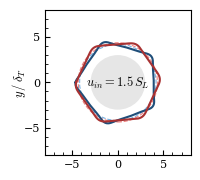

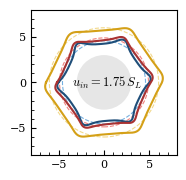

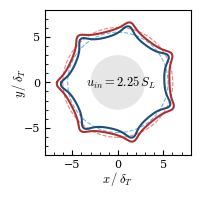

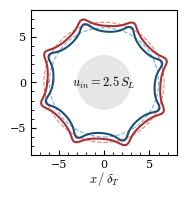

In [ ]:
"""Comparison of euqivalence ratio
"""

plot_run_list = [["01.50_02", "01.50_02"], ["01.75_01", "01.75_02", "01.75_02"], ["02.25_02", "02.25_02"], ["02.50_02", "02.50_02"]]
case_dir_1 = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/base_18.4k_phi_0.6")
case_dir_2 = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/base_18.4k_phi_0.75")
case_dir_3 = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/le1_18.4k_phi_0.75")
#t_final = [[50.0, 150.0, 150.0]]
t_final = [[100.00, 150.0], [50.0, 150.0, 150.0], [100.0, 150.0], [100.0, 150.0]]

tau_f_1 = 0.03676 
tau_f_2 = 0.03509

r_mean_comp = np.empty((len(plot_run_list), 2))

for i, run_list in enumerate(plot_run_list):
    fig, ax1 = plt.subplots(figsize=(w_plot_s*0.5, w_plot_s*0.5))
    
    for j, run in enumerate(run_list):
        t = t_final[i][j]
        #print(t)
        u_in, run_num = run.split("_")
        my_cmap = plt.get_cmap('plasma')

        colors = my_cmap(np.linspace(0, 0.9, 2))

        match j:
            case 0: 
                filepath = case_dir_1 / f"Uin_{u_in}_RUN{run_num}" / "database" / f"Isotherm_T_3_t_{t:.2f}.okc"
            case 1:
                filepath = case_dir_2 / f"Uin_{u_in}_RUN{run_num}" / "database" / f"Isotherm_T_3_t_{t:.2f}.okc"
            case 2:
                filepath = case_dir_3 / f"Uin_{u_in}_RUN{run_num}" / "database" / f"Isotherm_T_3_t_{t:.2f}.okc"

        df = extract_fields_from_okc(filepath, ['x', 'y'])
        theta_unsorted, r_mean, r_fluc_unsorted = cartesian_df_to_polar(df)

        # Get the indices that would sort theta and sort the arrays
        sorted_indices = np.argsort(theta_unsorted)
        theta = theta_unsorted[sorted_indices]
        r_fluc = r_fluc_unsorted[sorted_indices]

        if j == 0:  
            label = f"{r'$u_{in}='}{float(u_in)}{r'\, S_L$'}"
            if i == 4:  ax1.text(-7.0, 6.5, label, fontweight='bold')
            else:       ax1.text(-3.5, -0.5, label, fontweight='bold')

        x = (r_fluc + r_mean) * np.cos(theta)
        y = (r_fluc + r_mean) * np.sin(theta)
    
        ax1.plot(x, y, label=r'$l_{tot}}$', color=['#1f4e79', '#a83232', '#d4a017'][j], linewidth=1.5)
        circle = patches.Circle((0, 0), r_mean , facecolor='none', linewidth=0.8, edgecolor=['#76b0e0', '#f0827f', '#f2d98c'][j] , linestyle='--')
        ax1.add_patch(circle)

        
    circle = patches.Circle((0, 0), 3, facecolor='0.9', edgecolor='none')
    ax1.add_patch(circle)

    # Primary axis settings
    if i == 2 or i == 3:
        ax1.set_xlabel(r'$x \, / \, \delta_T$', labelpad=0)
        ax1.set_xticks([i for i in range(-10, 11, 5)])
    if i == 0 or i == 2:
        ax1.set_ylabel(r'$y \, / \, \delta_T$', labelpad=-3)
        ax1.set_yticks([i for i in range(-10, 11, 5)])
    ax1.tick_params(axis='both', which='both', labelcolor='black', direction='in')
    ax1.minorticks_on()
    ax1.set_aspect('equal')
    ax1.margins()
    ax1.set_xlim(-8, 8)
    ax1.set_ylim(-8, 8)
    #plt.tight_layout()
    plt.show()
    fig.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Paper/Figures Minipaper/Isotherm_comp_phi_0675_{run_list[0]}.png", dpi=300, bbox_inches='tight')

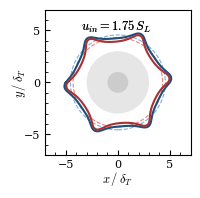

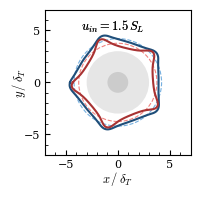

[[4.5652357  4.3052366 ]
 [4.20906441 3.76238557]]


In [42]:
"""Plot the two final isotherms of same inlet vel but different fixed point and plot the final isotherm for a different inlet Radius
"""

plot_run_list = [["01.75_01", "01.75_08"], ["01.50_01", "01.50_04"]]
case_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/base_18.4k_phi_0.6")
t_final = [[50.0, 100.0], [50.0, 100.0]]

r_mean_comp = np.empty((len(plot_run_list), 2))
for i, run_list in enumerate(plot_run_list):
    fig, ax1 = plt.subplots(figsize=(w_plot_s*0.5,w_plot_s*0.5))
    
    for j, run in enumerate(run_list):
        t = t_final[i][j]
        #print(t)
        u_in, run_num = run.split("_")
        my_cmap = plt.get_cmap('plasma')

        colors = my_cmap(np.linspace(0, 0.9, 2))

        filepath = case_dir / f"Uin_{u_in}_RUN{run_num}" / "database" / f"Isotherm_T_3_t_{t:.2f}.okc"
        df = extract_fields_from_okc(filepath, ['x', 'y'])
        theta_unsorted, r_mean, r_fluc_unsorted = cartesian_df_to_polar(df)

        # Get the indices that would sort theta and sort the arrays
        sorted_indices = np.argsort(theta_unsorted)
        theta = theta_unsorted[sorted_indices]
        r_fluc = r_fluc_unsorted[sorted_indices]

        if i == 0 and j == 1:
            theta += 0.08
        x = (r_fluc + r_mean) * np.cos(theta)
        y = (r_fluc + r_mean) * np.sin(theta)

        label = f"{r'$u_{in}='}{float(u_in)}{r'\, S_L$'}"
        ax1.text(-3.5, 5, label)

        ax1.plot(x, y, label=r'$l_{tot}}$', color=['#1f4e79', '#a83232'][j], linewidth=1.5)
        circle = patches.Circle((0, 0), r_mean, facecolor='none', linewidth=0.8, edgecolor=['#76b0e0', '#f0827f'][j] , linestyle='--')
        ax1.add_patch(circle)
        r_mean_comp[i, j] = r_mean
    circle = patches.Circle((0, 0), 3, facecolor='0.9', edgecolor='none')
    ax1.add_patch(circle)

    circle = patches.Circle((0, 0), 1, facecolor='0.8', edgecolor='none')
    ax1.add_patch(circle)
    # Primary axis settings
    ax1.set_xlabel(r'$x \, / \, \delta_T$', labelpad=0)
    ax1.set_ylabel(r'$y \, / \, \delta_T$', labelpad=-3)
    ax1.tick_params(axis='both', which='both', labelcolor='black', direction='in')
    ax1.minorticks_on()
    ax1.set_xticks([i for i in range(-10, 11, 5)])
    ax1.set_yticks([i for i in range(-10, 11, 5)])
    ax1.set_aspect('equal')
    ax1.margins()
    ax1.set_xlim(-7, 7)
    ax1.set_ylim(-7, 7)
    #plt.tight_layout()
    plt.show()
    fig.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Paper/Figures Minipaper/Isotherm_comp_{run_list[0]}_{run_list[1]}.png", dpi=300,bbox_inches='tight')

print(r_mean_comp)

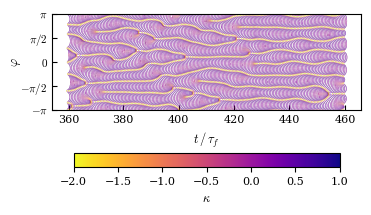

In [72]:
run_list = ["02.75_07"]
time_starts = [360]
time_stops  = [460]
time_steps  = [0.5]
case_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/base_18.4k_phi_0.6")
plot_pseudo_planar(case_dir, run_list, time_starts, time_stops, time_steps, 3, plot_dims=(w_plot_s, h_plot_s*1.5), plot_cb='horizontal', x_offs=[448])

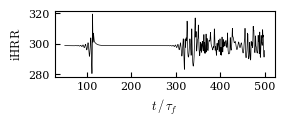

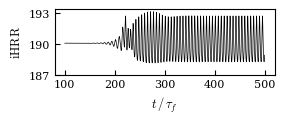

In [51]:
"""Plot the rotation of one into another
"""
run_list = ["02.75_04", "02.75_05", "02.75_06",  "02.75_07"]
time_break = 111.0
run_break = 100 - time_break % 1
time_step = 1
t_off = 50
case_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/base_18.4k_phi_0.6")

def plot_hrr_tot(case_dir, run_list, y_ticks):
    # time_starts = [0, 100, 200]
    # time_stops  = [50, 200, 300]

    ihrr_timeseries = np.empty((0,2)) 

    for i, run in enumerate(run_list):

        u_in, run_num = run.split("_")
        ihrr_dir = case_dir / f"Uin_{u_in}_RUN{run_num}/iHRR.csv"
        df = pd.read_csv(ihrr_dir)
        ihrr_timeseries = np.append(ihrr_timeseries, df.to_numpy(), axis=0)

    # ihrr_stop_pad = 2
    # ihrr_start_pad = 2
    # start_ihrr = np.where(ihrr_timeseries[:,0] == (time_starts[0] + t_off - ihrr_start_pad))[0][0]
    # stop_ihrr = np.where(ihrr_timeseries[:,0] == (time_stops[-1] + ihrr_stop_pad))[0][0]
    fig, ax1 = plt.subplots(figsize=(w_plot_mw*0.5, w_plot_mw*0.15))

    ax1.plot(ihrr_timeseries[:,0], ihrr_timeseries[:,1], label=r'$l_{tot}}$', color='black', linewidth=0.5)
    ax1.set_xlabel(r'$t \, / \, \tau_f$')
    ax1.set_ylabel(r'$\text{iHRR}$')
    # ax1.set_ylim(bottom=140)
    ax1.tick_params(axis='both', which='both', labelcolor='black', direction='in')
    ax1.set_yticks(y_ticks)

    plt.show()
    fig.savefig(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Paper/Figures Minipaper/iHRR_{run}.png", dpi=300,bbox_inches='tight')

plot_hrr_tot(case_dir, run_list, [280, 300, 320])
run_list=["01.75_04", "01.75_05", "01.75_06", "01.75_07"]
time_break = 111.0
run_break = 100 - time_break % 1
time_step = 1
t_off = 50
case_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/base_18.4k_phi_0.6")
plot_hrr_tot(case_dir, run_list, [187, 190, 193])